Knudson et al., (2021). PyEI: A Python package for ecological inference. Journal of Open Source Software, 6(64), 3397, https://doi.org/10.21105/joss.03397

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from pyei import TwoByTwoEI


/Users/tonymac/miniconda3/envs/cse354/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
race_columns = {
    'WHITE': 'WHT_NHSP22',
    'BLACK': 'BLK_NHSP22',
    'HISPANIC': 'HSP_POP22',
    'ASIAN': 'ASN_NHSP22',
}
election_columns = {
    'REPUBLICAN': 'TOT_REP',
    'DEMOCRATIC': 'TOT_DEM',
}
income_columns = ['0_35K', '35K_60K', '60K_100K', '100K_125K', '125K_150K', '150K_MORE']

### Functions

In [3]:
def calculate_population_distribution(df, race_columns, columns_to_keep):
    # Recalculate total population as the sum of race-specific columns
    df['TOTAL_POP_RECALCULATED'] = df[list(race_columns.values())].sum(axis=1)
    
    # Calculate percentages for each race column
    for race, col in race_columns.items():
        percentage_col = f"{race}_PERCENT"
        df[percentage_col] = df[col] / df['TOTAL_POP_RECALCULATED']
    
    # Add the percentage columns to the columns_to_keep list
    columns_to_keep += [f"{race}_PERCENT" for race in race_columns.keys()]

    return df[columns_to_keep]




In [4]:
def calculate_voting_distribution(df, election_columns, columns_to_keep):
    df['TOTAL_VOTES_RECALCULATED'] = df[list(election_columns.values())].sum(axis=1)
    
    for party, col in election_columns.items():
        percentage_col = f"{party}_PERCENT"
        df[percentage_col] = (df[col] / df['TOTAL_VOTES_RECALCULATED'])
    columns_to_keep += [f"{party}_PERCENT" for party in election_columns.keys()]
    return df[columns_to_keep]

In [5]:
def calculate_income_distribution(df, income_columns, columns_to_keep):
    df['TOTAL_INCOME_POPULATION'] = df[income_columns].sum(axis=1)
    
    for income_range in income_columns:
        percentage_col = f"{income_range}_PERCENT"
        df[percentage_col] = df[income_range] / df['TOTAL_INCOME_POPULATION']
    
    columns_to_keep += [f"{income_range}_PERCENT" for income_range in income_columns]

    return df[columns_to_keep]

In [6]:
def run_ecological_inference(
    df, 
    demographic_col, 
    voting_col, 
    total_votes_col, 
    demographic_group_name="Demographic Group", 
    candidate_name="Candidate", 
    precinct_col="UNIQUE_ID",
    model_name="king99_pareto_modification",
    pareto_scale = 3,
    pareto_shape = 3,
):
    # Extract data
    X = np.array(df[demographic_col])  # Demographic percentage
    T = np.array(df[voting_col])       # Voting percentage
    N = np.array(df[total_votes_col])  # Total votes
    precinct_names = df[precinct_col]  # Precinct names

    ei = TwoByTwoEI(
        model_name=model_name,
        pareto_scale=pareto_scale,
        pareto_shape=pareto_shape
    )

    # Fit the model
    ei.fit(
        X, T, N,
        demographic_group_name=demographic_group_name,
        candidate_name=candidate_name,
        precinct_names=precinct_names,
        # draws=8000,
        # tune=4000,
        # target_accept=0.95
    )

    # Display a summary
    summary = ei.summary()
    print(summary)

    return ei, summary


In [7]:
def run_ecological_inference_normal(
    df, 
    demographic_col, 
    voting_col, 
    total_votes_col, 
    demographic_group_name="Demographic Group", 
    candidate_name="Candidate", 
    precinct_col="UNIQUE_ID",
    model_name="truncated_normal",
):
    # Extract data
    X = np.array(df[demographic_col])  # Demographic percentage
    T = np.array(df[voting_col])       # Voting percentage
    N = np.array(df[total_votes_col])  # Total votes
    precinct_names = df[precinct_col]  # Precinct names

    ei = TwoByTwoEI(
        model_name=model_name
    )

    # Fit the model
    ei.fit(
        X, T, N,
        demographic_group_name=demographic_group_name,
        candidate_name=candidate_name,
        precinct_names=precinct_names,
    )

    # Display a summary
    summary = ei.summary()
    print(summary)

    return ei, summary


In [230]:
class json_serialize(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

## South Carolina

### Import data

In [387]:
sc_election_gov_df = pd.read_json('states/south_carolina/election/sc_election_gov_22.json')
sc_race_df = pd.read_json('states/south_carolina/demographics/south_carolina_precincts_racial_population.json')
sc_economic_df = pd.read_json('states/south_carolina/economic/south_carolina_precincts_household_income.json')
sc_region_type_df = pd.read_json('states/south_carolina/geodata/south_carolina_precincts_region_type.json')

In [388]:
sc_candidate_mapping = {
    'REPUBLICAN': 'Henry McMaster (Republican Party)',
    'DEMOCRATIC': 'Joe Cunningham (Democratic Party)'
}

### Main Script

#### Preprocess data

##### Racial Group

In [389]:
print(sc_race_df.columns.values)

['UNIQUE_ID' 'NAME' 'Prec_Code' 'CONG_DIST' 'TOT_POP22' 'NHSP_POP22'
 'HSP_POP22' 'WHT_NHSP22' 'BLK_NHSP22' 'ASN_NHSP22' 'OTH_NHSP22']


In [390]:
columns_to_keep = ['UNIQUE_ID', 'TOT_POP22']

In [391]:
sc_race_with_percentages = calculate_population_distribution(sc_race_df, race_columns, columns_to_keep)

In [392]:
columns_to_keep = ['UNIQUE_ID', 'TOT_VOT']

In [393]:
sc_election_gov_with_percentages = calculate_voting_distribution(sc_election_gov_df, election_columns, columns_to_keep)

In [394]:
sc_race_merged_ei_df = pd.merge(sc_election_gov_with_percentages, sc_race_with_percentages, on='UNIQUE_ID', how='left')

In [395]:
sc_race_merged_ei_df.fillna(0, inplace=True)

In [396]:
# remove TOT_POP22
sc_race_merged_ei_df = sc_race_merged_ei_df.drop(columns=['TOT_POP22'])
sc_region_type_df = sc_region_type_df.drop(columns=['TOT_POP22'])



In [ ]:
# merge with region type
sc_race_merged_ei_df = pd.merge(sc_race_merged_ei_df, sc_region_type_df, on='UNIQUE_ID', how='left')


In [398]:
print(sc_race_merged_ei_df.columns.values)  

['UNIQUE_ID' 'TOT_VOT' 'REPUBLICAN_PERCENT' 'DEMOCRATIC_PERCENT'
 'WHITE_PERCENT' 'BLACK_PERCENT' 'HISPANIC_PERCENT' 'ASIAN_PERCENT'
 'region_type']


In [399]:
sc_race_merged_ei_rural_df = sc_race_merged_ei_df[sc_race_merged_ei_df['region_type'] == 'rural']

sc_race_merged_ei_suburban_df = sc_race_merged_ei_df[sc_race_merged_ei_df['region_type'] == 'suburban']

sc_race_merged_ei_urban_df = sc_race_merged_ei_df[sc_race_merged_ei_df['region_type'] == 'urban']


In [400]:
# sc_race_merged_ei_df = normalize_percent_columns(sc_race_merged_ei_df)

In [401]:
sc_race_merged_ei_df = sc_race_merged_ei_df[sc_race_merged_ei_df['TOT_VOT']>0]

sc_race_merged_ei_rural_df = sc_race_merged_ei_rural_df[sc_race_merged_ei_rural_df['TOT_VOT']>0]

sc_race_merged_ei_suburban_df = sc_race_merged_ei_suburban_df[sc_race_merged_ei_suburban_df['TOT_VOT']>0]

sc_race_merged_ei_urban_df = sc_race_merged_ei_urban_df[sc_race_merged_ei_urban_df['TOT_VOT']>0]

In [402]:
sc_race_merged_ei_df = sc_race_merged_ei_df.sample(n=100, random_state=42)

sc_race_merged_ei_rural_df = sc_race_merged_ei_rural_df.sample(n=100, random_state=42)

sc_race_merged_ei_suburban_df = sc_race_merged_ei_suburban_df.sample(n=100, random_state=42)

sc_race_merged_ei_urban_df = sc_race_merged_ei_urban_df.sample(n=100, random_state=42)

##### Economic Group

In [403]:
columns_to_keep = ['UNIQUE_ID']

In [404]:
sc_economic_with_percentages = calculate_income_distribution(sc_economic_df, income_columns, columns_to_keep)

In [405]:
sc_economic_merged_ei_df = pd.merge(sc_election_gov_with_percentages, sc_economic_with_percentages, on='UNIQUE_ID', how='left')

In [406]:
sc_economic_merged_ei_df.fillna(0, inplace=True)

In [407]:
sc_economic_merged_ei_df = pd.merge(sc_economic_merged_ei_df, sc_region_type_df, on='UNIQUE_ID', how='left')

In [408]:
sc_economic_merged_ei_rural_df = sc_economic_merged_ei_df[sc_economic_merged_ei_df['region_type'] == 'rural']

sc_economic_merged_ei_suburban_df = sc_economic_merged_ei_df[sc_economic_merged_ei_df['region_type'] == 'suburban']

sc_economic_merged_ei_urban_df = sc_economic_merged_ei_df[sc_economic_merged_ei_df['region_type'] == 'urban']

In [409]:
print(sc_economic_merged_ei_rural_df[sc_economic_merged_ei_rural_df['TOT_VOT'] > 0].shape)

(1411, 11)


In [410]:
sc__merged_ei_df = sc_economic_merged_ei_df[sc_economic_merged_ei_df['TOT_VOT']>0]

sc_economic_merged_ei_rural_df = sc_economic_merged_ei_rural_df[sc_economic_merged_ei_rural_df['TOT_VOT']>0]

sc_economic_merged_ei_suburban_df = sc_economic_merged_ei_suburban_df[sc_economic_merged_ei_suburban_df['TOT_VOT']>0]

sc_economic_merged_ei_urban_df = sc_economic_merged_ei_urban_df[sc_economic_merged_ei_urban_df['TOT_VOT']>0]

In [411]:
print(sc_economic_merged_ei_rural_df)

                    UNIQUE_ID  TOT_VOT  REPUBLICAN_PERCENT  \
0     ABBEVILLE_PRECINCT_001_      975            0.736410   
1     ABBEVILLE_PRECINCT_002_      628            0.356688   
2     ABBEVILLE_PRECINCT_003_      574            0.585366   
3     ABBEVILLE_PRECINCT_004_      437            0.723112   
4     ABBEVILLE_PRECINCT_005_      722            0.829640   
...                       ...      ...                 ...   
2251  CLARENDON_PRECINCT_019_      160            0.425000   
2252  CLARENDON_PRECINCT_020_     1266            0.632701   
2253  CLARENDON_PRECINCT_021_      182            0.186813   
2254  CLARENDON_PRECINCT_022_      467            0.218415   
2255  CLARENDON_PRECINCT_023_      497            0.814889   

      DEMOCRATIC_PERCENT  0_35K_PERCENT  35K_60K_PERCENT  60K_100K_PERCENT  \
0               0.263590       0.208333         0.200000          0.276667   
1               0.643312       0.472222         0.418981          0.069444   
2               0.414

In [412]:
sc_economic_merged_ei_df = sc_economic_merged_ei_df.sample(n=100, random_state=42)

sc_economic_merged_ei_rural_df = sc_economic_merged_ei_rural_df.sample(n=100, random_state=42)

sc_economic_merged_ei_suburban_df = sc_economic_merged_ei_suburban_df.sample(n=100, random_state=42)

sc_economic_merged_ei_urban_df = sc_economic_merged_ei_urban_df.sample(n=100, random_state=42)

### Running EI models

#### Racial Run

##### DEMOCRATIC Run

In [413]:
dem_white_ei, dem_white_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.617843
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:04.326635
Transforming variables...
Transformation time = 0:00:17.679671


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Joe Cunningham (Democratic Party) is
        0.262
        The posterior mean for the district-level voting preference of
        non-White for Joe Cunningham (Democratic Party) is
        0.652
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Joe Cunningham (Democratic Party) is
        [0.2249661  0.30248031]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Joe Cunningham (Democratic Party) is
        [0.57740592 0.72231948]
        


In [414]:
dem_white_ei_rural, dem_white_summary_rural = run_ecological_inference(
    df=sc_race_merged_ei_rural_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.120294
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.835855
Transforming variables...
Transformation time = 0:00:15.341631


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Joe Cunningham (Democratic Party) is
        0.307
        The posterior mean for the district-level voting preference of
        non-White for Joe Cunningham (Democratic Party) is
        0.608
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Joe Cunningham (Democratic Party) is
        [0.26469362 0.35144487]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Joe Cunningham (Democratic Party) is
        [0.54328383 0.66985286]
        


In [415]:
dem_white_ei_subrban, dem_white_summary_suburban = run_ecological_inference(
    df=sc_race_merged_ei_suburban_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.344915
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.192098
Transforming variables...
Transformation time = 0:00:16.433948


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Joe Cunningham (Democratic Party) is
        0.226
        The posterior mean for the district-level voting preference of
        non-White for Joe Cunningham (Democratic Party) is
        0.823
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Joe Cunningham (Democratic Party) is
        [0.20307142 0.25376989]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Joe Cunningham (Democratic Party) is
        [0.75614752 0.87493041]
        


In [416]:
dem_white_ei_urban, dem_white_summary_urban = run_ecological_inference(
    df=sc_race_merged_ei_urban_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:04.545497
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.515359
Transforming variables...
Transformation time = 0:00:19.279535


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Joe Cunningham (Democratic Party) is
        0.245
        The posterior mean for the district-level voting preference of
        non-White for Joe Cunningham (Democratic Party) is
        0.797
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Joe Cunningham (Democratic Party) is
        [0.2177605  0.27439698]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Joe Cunningham (Democratic Party) is
        [0.71398027 0.87022425]
        


In [417]:
dem_black_ei, dem_black_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.454066
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.222107
Transforming variables...
Transformation time = 0:00:19.035338


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Joe Cunningham (Democratic Party) is
        0.854
        The posterior mean for the district-level voting preference of
        non-Black for Joe Cunningham (Democratic Party) is
        0.287
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Joe Cunningham (Democratic Party) is
        [0.77473119 0.91965745]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Joe Cunningham (Democratic Party) is
        [0.27236351 0.30491843]
        


In [418]:
dem_black_ei_rural, dem_black_summary_rural = run_ecological_inference(
    df=sc_race_merged_ei_rural_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.800915
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.294746
Transforming variables...
Transformation time = 0:00:16.890619


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Joe Cunningham (Democratic Party) is
        0.758
        The posterior mean for the district-level voting preference of
        non-Black for Joe Cunningham (Democratic Party) is
        0.315
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Joe Cunningham (Democratic Party) is
        [0.67120807 0.83219176]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Joe Cunningham (Democratic Party) is
        [0.29019531 0.34223453]
        


In [419]:
dem_black_ei_suburban, dem_black_summary_suburban = run_ecological_inference(
    df=sc_race_merged_ei_suburban_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.233358
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.107423
Transforming variables...
Transformation time = 0:00:16.735051


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Joe Cunningham (Democratic Party) is
        0.849
        The posterior mean for the district-level voting preference of
        non-Black for Joe Cunningham (Democratic Party) is
        0.297
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Joe Cunningham (Democratic Party) is
        [0.7748046  0.90906691]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Joe Cunningham (Democratic Party) is
        [0.28018004 0.31614212]
        


In [420]:
dem_black_ei_urban, dem_black_summary_urban = run_ecological_inference(
    df=sc_race_merged_ei_urban_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.311657
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.890666
Transforming variables...
Transformation time = 0:00:21.695620


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Joe Cunningham (Democratic Party) is
        0.880
        The posterior mean for the district-level voting preference of
        non-Black for Joe Cunningham (Democratic Party) is
        0.290
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Joe Cunningham (Democratic Party) is
        [0.79062693 0.94942589]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Joe Cunningham (Democratic Party) is
        [0.27452152 0.31039653]
        


In [421]:
dem_asian_ei, dem_asian_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:03.243826
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.046414
Transforming variables...
Transformation time = 0:00:13.890099


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Joe Cunningham (Democratic Party) is
        0.580
        The posterior mean for the district-level voting preference of
        non-Asian for Joe Cunningham (Democratic Party) is
        0.384
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Joe Cunningham (Democratic Party) is
        [0.09737233 0.96607816]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Joe Cunningham (Democratic Party) is
        [0.3777878  0.39158261]
        


In [422]:
dem_asian_ei_rural, dem_asian_summary_rural = run_ecological_inference(
    df=sc_race_merged_ei_rural_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.213048
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.052729
Transforming variables...
Transformation time = 0:00:11.449931


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Joe Cunningham (Democratic Party) is
        0.433
        The posterior mean for the district-level voting preference of
        non-Asian for Joe Cunningham (Democratic Party) is
        0.418
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Joe Cunningham (Democratic Party) is
        [0.04065916 0.92053631]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Joe Cunningham (Democratic Party) is
        [0.41328643 0.42246997]
        


In [423]:
dem_asian_ei_suburban, dem_asian_summary_suburban = run_ecological_inference(
    df=sc_race_merged_ei_suburban_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.227308
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.033471
Transforming variables...
Transformation time = 0:00:18.871656


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Joe Cunningham (Democratic Party) is
        0.703
        The posterior mean for the district-level voting preference of
        non-Asian for Joe Cunningham (Democratic Party) is
        0.414
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Joe Cunningham (Democratic Party) is
        [0.2285832  0.94777913]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Joe Cunningham (Democratic Party) is
        [0.40706573 0.42569778]
        


In [424]:
dem_asian_ei_urban, dem_asian_summary_urban = run_ecological_inference(
    df=sc_race_merged_ei_urban_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.336957
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.245671
Transforming variables...
Transformation time = 0:00:35.679074


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Joe Cunningham (Democratic Party) is
        0.835
        The posterior mean for the district-level voting preference of
        non-Asian for Joe Cunningham (Democratic Party) is
        0.388
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Joe Cunningham (Democratic Party) is
        [0.47992485 0.98784259]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Joe Cunningham (Democratic Party) is
        [0.38329112 0.39678897]
        


In [425]:
dem_hispanic_ei, rep_asian_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.394726
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.504416
Transforming variables...
Transformation time = 0:00:11.333059


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Joe Cunningham (Democratic Party) is
        0.815
        The posterior mean for the district-level voting preference of
        non-Hispanic for Joe Cunningham (Democratic Party) is
        0.364
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Joe Cunningham (Democratic Party) is
        [0.52750502 0.96547722]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Joe Cunningham (Democratic Party) is
        [0.35466611 0.37994795]
        


In [426]:
dem_hispanic_ei_rural, rep_asian_summary_rural = run_ecological_inference(
    df=sc_race_merged_ei_rural_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:04.628249
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.393594
Transforming variables...
Transformation time = 0:00:21.896009


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Joe Cunningham (Democratic Party) is
        0.759
        The posterior mean for the district-level voting preference of
        non-Hispanic for Joe Cunningham (Democratic Party) is
        0.407
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Joe Cunningham (Democratic Party) is
        [0.40987749 0.9732003 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Joe Cunningham (Democratic Party) is
        [0.39857454 0.42012288]
        


In [427]:
dem_hispanic_ei_suburban, rep_asian_summary_suburban = run_ecological_inference(
    df=sc_race_merged_ei_suburban_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.350730
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.210484
Transforming variables...
Transformation time = 0:00:16.360568


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Joe Cunningham (Democratic Party) is
        0.784
        The posterior mean for the district-level voting preference of
        non-Hispanic for Joe Cunningham (Democratic Party) is
        0.391
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Joe Cunningham (Democratic Party) is
        [0.48156716 0.96796177]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Joe Cunningham (Democratic Party) is
        [0.37505303 0.41575678]
        


In [428]:
dem_hispanic_ei_urban, rep_asian_summary_urban = run_ecological_inference(
    df=sc_race_merged_ei_urban_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.206751
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.062282
Transforming variables...
Transformation time = 0:00:10.153622


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Joe Cunningham (Democratic Party) is
        0.636
        The posterior mean for the district-level voting preference of
        non-Hispanic for Joe Cunningham (Democratic Party) is
        0.380
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Joe Cunningham (Democratic Party) is
        [0.31661346 0.89899199]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Joe Cunningham (Democratic Party) is
        [0.35861571 0.40421561]
        


##### Running Repulican

In [429]:
rep_white_ei, rep_white_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.228725
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.166014
Transforming variables...
Transformation time = 0:00:18.296050


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Henry McMaster (Republican Party) is
        0.738
        The posterior mean for the district-level voting preference of
        non-White for Henry McMaster (Republican Party) is
        0.347
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Henry McMaster (Republican Party) is
        [0.69558189 0.77695831]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Henry McMaster (Republican Party) is
        [0.27479148 0.42365758]
        


In [430]:
rep_white_ei_rural, rep_white_summary_rural = run_ecological_inference(
    df=sc_race_merged_ei_rural_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.214985
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.937288
Transforming variables...
Transformation time = 0:00:15.279535


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Henry McMaster (Republican Party) is
        0.692
        The posterior mean for the district-level voting preference of
        non-White for Henry McMaster (Republican Party) is
        0.393
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Henry McMaster (Republican Party) is
        [0.64792469 0.73146283]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Henry McMaster (Republican Party) is
        [0.33053386 0.45750748]
        


In [431]:
rep_white_ei_suburban, rep_white_summary_suburban = run_ecological_inference(
    df=sc_race_merged_ei_suburban_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:03.286854
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.942762
Transforming variables...
Transformation time = 0:00:16.425811


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Henry McMaster (Republican Party) is
        0.775
        The posterior mean for the district-level voting preference of
        non-White for Henry McMaster (Republican Party) is
        0.173
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Henry McMaster (Republican Party) is
        [0.74806912 0.79894412]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Henry McMaster (Republican Party) is
        [0.12025289 0.23670251]
        


In [432]:
rep_white_ei_urban, rep_white_summary_urban= run_ecological_inference(
    df=sc_race_merged_ei_urban_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.191962
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.980400
Transforming variables...
Transformation time = 0:00:18.020689


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Henry McMaster (Republican Party) is
        0.756
        The posterior mean for the district-level voting preference of
        non-White for Henry McMaster (Republican Party) is
        0.202
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Henry McMaster (Republican Party) is
        [0.72617541 0.78080792]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Henry McMaster (Republican Party) is
        [0.1333543  0.28624826]
        


In [433]:
rep_black_ei, rep_black_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.224395
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.019936
Transforming variables...
Transformation time = 0:00:17.551886


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Henry McMaster (Republican Party) is
        0.144
        The posterior mean for the district-level voting preference of
        non-Black for Henry McMaster (Republican Party) is
        0.713
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Henry McMaster (Republican Party) is
        [0.08221684 0.22580008]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Henry McMaster (Republican Party) is
        [0.6949756  0.72738799]
        


In [434]:
rep_black_ei_rural, rep_black_summary_rural = run_ecological_inference(
    df=sc_race_merged_ei_rural_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.210419
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.332075
Transforming variables...
Transformation time = 0:00:15.525457


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Henry McMaster (Republican Party) is
        0.246
        The posterior mean for the district-level voting preference of
        non-Black for Henry McMaster (Republican Party) is
        0.683
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Henry McMaster (Republican Party) is
        [0.1661619  0.33490337]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Henry McMaster (Republican Party) is
        [0.65465975 0.70828476]
        


In [435]:
rep_black_ei_suburban, rep_black_summary_suburban = run_ecological_inference(
    df=sc_race_merged_ei_suburban_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...


Compilation time = 0:00:01.243227
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.994257
Transforming variables...
Transformation time = 0:00:17.171694


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Henry McMaster (Republican Party) is
        0.151
        The posterior mean for the district-level voting preference of
        non-Black for Henry McMaster (Republican Party) is
        0.703
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Henry McMaster (Republican Party) is
        [0.09316185 0.22154156]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Henry McMaster (Republican Party) is
        [0.68391276 0.71909495]
        


In [436]:
rep_black_ei_urban, rep_black_summary_urban = run_ecological_inference(
    df=sc_race_merged_ei_urban_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.270971
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:05.353269
Transforming variables...
Transformation time = 0:00:25.181047


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Henry McMaster (Republican Party) is
        0.117
        The posterior mean for the district-level voting preference of
        non-Black for Henry McMaster (Republican Party) is
        0.710
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Henry McMaster (Republican Party) is
        [0.04839946 0.2026908 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Henry McMaster (Republican Party) is
        [0.69218886 0.72616381]
        


In [437]:
rep_asian_ei, rep_asian_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.274681
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.651109
Transforming variables...
Transformation time = 0:00:10.758277


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Henry McMaster (Republican Party) is
        0.444
        The posterior mean for the district-level voting preference of
        non-Asian for Henry McMaster (Republican Party) is
        0.615
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Henry McMaster (Republican Party) is
        [0.05827534 0.89292198]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Henry McMaster (Republican Party) is
        [0.60842624 0.62156362]
        


In [438]:
rep_asian_ei_rural, rep_asian_summary_rural = run_ecological_inference(
    df=sc_race_merged_ei_rural_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.404292
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.190417
Transforming variables...
Transformation time = 0:00:13.832679


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Henry McMaster (Republican Party) is
        0.375
        The posterior mean for the district-level voting preference of
        non-Asian for Henry McMaster (Republican Party) is
        0.583
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Henry McMaster (Republican Party) is
        [0.00296738 0.93486277]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Henry McMaster (Republican Party) is
        [0.57775882 0.58784877]
        


In [439]:
rep_asian_ei_suburban, rep_asian_summary_suburban = run_ecological_inference(
    df=sc_race_merged_ei_suburban_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.336364
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.982725
Transforming variables...
Transformation time = 0:00:12.511125


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Henry McMaster (Republican Party) is
        0.383
        The posterior mean for the district-level voting preference of
        non-Asian for Henry McMaster (Republican Party) is
        0.584
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Henry McMaster (Republican Party) is
        [0.09629048 0.85235297]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Henry McMaster (Republican Party) is
        [0.57187558 0.59194884]
        


In [440]:
rep_asian_ei_urban, rep_asian_summary_urban = run_ecological_inference(
    df=sc_race_merged_ei_urban_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.228573
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.877473
Transforming variables...
Transformation time = 0:00:14.592261


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Henry McMaster (Republican Party) is
        0.154
        The posterior mean for the district-level voting preference of
        non-Asian for Henry McMaster (Republican Party) is
        0.612
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Henry McMaster (Republican Party) is
        [0.01038163 0.55547444]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Henry McMaster (Republican Party) is
        [0.60238474 0.61677455]
        


In [441]:
rep_hispanic_ei, rep_hispanic_summary = run_ecological_inference(
    df=sc_race_merged_ei_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.262157
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.297819
Transforming variables...
Transformation time = 0:00:18.710674


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Henry McMaster (Republican Party) is
        0.169
        The posterior mean for the district-level voting preference of
        non-Hispanic for Henry McMaster (Republican Party) is
        0.637
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Henry McMaster (Republican Party) is
        [0.01223015 0.41240426]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Henry McMaster (Republican Party) is
        [0.62255158 0.64628853]
        


In [442]:
rep_hispanic_ei_rural, rep_hispanic_summary_rural = run_ecological_inference(
    df=sc_race_merged_ei_rural_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:04.937825
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.082913
Transforming variables...
Transformation time = 0:00:22.323037


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Henry McMaster (Republican Party) is
        0.254
        The posterior mean for the district-level voting preference of
        non-Hispanic for Henry McMaster (Republican Party) is
        0.592
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Henry McMaster (Republican Party) is
        [0.03573202 0.62188472]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Henry McMaster (Republican Party) is
        [0.57851122 0.60097935]
        


In [443]:
rep_hispanic_ei_suburban, rep_hispanic_summary_suburban = run_ecological_inference(
    df=sc_race_merged_ei_suburban_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.302044
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.357113
Transforming variables...
Transformation time = 0:00:24.327489


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Henry McMaster (Republican Party) is
        0.246
        The posterior mean for the district-level voting preference of
        non-Hispanic for Henry McMaster (Republican Party) is
        0.607
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Henry McMaster (Republican Party) is
        [0.05601038 0.53245512]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Henry McMaster (Republican Party) is
        [0.58346503 0.62261474]
        


In [444]:
rep_hispanic_ei_urban, rep_hispanic_summary_urban = run_ecological_inference(
    df=sc_race_merged_ei_urban_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.215295
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.006003
Transforming variables...
Transformation time = 0:00:11.701797


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Henry McMaster (Republican Party) is
        0.345
        The posterior mean for the district-level voting preference of
        non-Hispanic for Henry McMaster (Republican Party) is
        0.622
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Henry McMaster (Republican Party) is
        [0.07656643 0.66855293]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Henry McMaster (Republican Party) is
        [0.5971112  0.64307283]
        


#### Econ Run

##### Dem Run

In [445]:
dem_0_35_ei, dem_0_35_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.190088
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.084546
Transforming variables...
Transformation time = 0:00:17.697517


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democratic Party) is
        0.636
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democratic Party) is
        0.342
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democratic Party) is
        [0.50920862 0.74858979]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democratic Party) is
        [0.30835459 0.38064602]
        


In [446]:
dem_0_35_ei_rural, dem_0_35_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.210246
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.259683
Transforming variables...
Transformation time = 0:00:17.360628


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democratic Party) is
        0.564
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democratic Party) is
        0.370
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democratic Party) is
        [0.4489041  0.66858943]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democratic Party) is
        [0.33230706 0.41095475]
        


In [447]:
dem_0_35_ei_suburban, dem_0_35_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.185102
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:04.771492
Transforming variables...
Transformation time = 0:00:18.864438


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democratic Party) is
        0.642
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democratic Party) is
        0.354
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democratic Party) is
        [0.52116911 0.75442519]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democratic Party) is
        [0.319208  0.3925246]
        


In [448]:
dem_0_35_ei_urban, dem_0_35_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.385696
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.119385
Transforming variables...
Transformation time = 0:00:19.810804


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democratic Party) is
        0.644
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democratic Party) is
        0.337
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Joe Cunningham (Democratic Party) is
        [0.48676505 0.77790372]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Joe Cunningham (Democratic Party) is
        [0.30546145 0.37548426]
        


In [449]:
dem_35_60_ei, dem_35_60_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.438596
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.587972
Transforming variables...
Transformation time = 0:00:18.473326


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.605
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.367
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.40723579 0.79367214]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.32770319 0.40863896]
        


In [450]:
dem_35_60_ei_rural, dem_35_60_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.368037
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.921088
Transforming variables...
Transformation time = 0:00:13.398060


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.532
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.398
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.35200591 0.69027431]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.36543653 0.43710305]
        


In [451]:
dem_35_60_ei_suburban, dem_35_60_summary_rural_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.187128
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.044966
Transforming variables...
Transformation time = 0:00:17.495680


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.690
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.353
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.51689064 0.82953472]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.31721384 0.39641799]
        


In [452]:
dem_35_60_ei_urban, dem_35_60_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.197282
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.814805
Transforming variables...
Transformation time = 0:00:18.589857


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.726
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.317
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.50170162 0.88404166]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.27769208 0.37330583]
        


In [453]:
dem_60_100_ei, dem_60_100_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:03.652227
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.920595
Transforming variables...
Transformation time = 0:00:17.107932


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.554
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.370
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.30588012 0.76767623]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.31297022 0.43503468]
        


In [454]:
dem_60_100_ei_rural, dem_60_100_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.243948
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.027610
Transforming variables...
Transformation time = 0:00:16.018307


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.538
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.394
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.36608352 0.71146588]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.35527307 0.43323524]
        


In [455]:
dem_60_100_ei_suburban, dem_60_100_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.223229
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.988023
Transforming variables...
Transformation time = 0:00:17.339338


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.499
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.393
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.31972993 0.66782828]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.34275382 0.44576697]
        


In [456]:
dem_60_100_ei_urban, dem_60_100_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.370940
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.247505
Transforming variables...
Transformation time = 0:00:27.993950


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.383
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        0.399
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.13989534 0.69365347]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Joe Cunningham (Democratic Party) is
        [0.29812922 0.47785792]
        


In [457]:
dem_100_125_ei, dem_100_125_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.337309
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.357026
Transforming variables...
Transformation time = 0:00:19.087158


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democratic Party) is
        0.666
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democratic Party) is
        0.381
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democratic Party) is
        [0.35367444 0.89336771]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democratic Party) is
        [0.35758234 0.41343748]
        


In [458]:
dem_100_125_ei_rural, dem_100_125_summar_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.232183
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.417758
Transforming variables...
Transformation time = 0:00:14.042952


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democratic Party) is
        0.659
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democratic Party) is
        0.401
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democratic Party) is
        [0.14053623 0.98153718]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democratic Party) is
        [0.37594022 0.43912553]
        


In [459]:
dem_100_125_ei_suburban, dem_100_125_summar_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:07.056357
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.360576
Transforming variables...
Transformation time = 0:00:15.963665


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democratic Party) is
        0.686
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democratic Party) is
        0.387
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democratic Party) is
        [0.30843056 0.93343872]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democratic Party) is
        [0.3589863  0.42975197]
        


In [460]:
dem_100_125_ei_urban, dem_100_125_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.406193
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.081742
Transforming variables...
Transformation time = 0:00:17.819988


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democratic Party) is
        0.410
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democratic Party) is
        0.396
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Joe Cunningham (Democratic Party) is
        [0.11071457 0.78075185]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Joe Cunningham (Democratic Party) is
        [0.3525111  0.43067286]
        


In [461]:
dem_125_150_ei, dem_125_150_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.499827
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.113115
Transforming variables...
Transformation time = 0:00:20.096772


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democratic Party) is
        0.384
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democratic Party) is
        0.407
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democratic Party) is
        [0.00618193 0.98219276]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democratic Party) is
        [0.36400009 0.43502468]
        


In [462]:
dem_125_150_ei_rural, dem_125_150_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.550924
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.463677
Transforming variables...
Transformation time = 0:00:17.318012


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democratic Party) is
        0.279
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democratic Party) is
        0.423
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democratic Party) is
        [0.02461764 0.7385104 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democratic Party) is
        [0.39783901 0.43799032]
        


In [463]:
dem_125_150_ei_suburban, dem_125_150_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.023614
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.508240
Transforming variables...
Transformation time = 0:00:21.217145


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democratic Party) is
        0.451
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democratic Party) is
        0.415
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democratic Party) is
        [0.07093908 0.90384854]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democratic Party) is
        [0.38455483 0.44109781]
        


In [464]:
dem_125_150_ei_urban, dem_125_150_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.307540
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.281757
Transforming variables...
Transformation time = 0:00:20.515774


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democratic Party) is
        0.283
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democratic Party) is
        0.406
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Joe Cunningham (Democratic Party) is
        [0.0122834 0.9572059]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Joe Cunningham (Democratic Party) is
        [0.34692781 0.43067751]
        


In [465]:
dem_150_more_ei, dem_150_more_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:05.985681
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.816706
Transforming variables...
Transformation time = 0:00:19.260595


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Joe Cunningham (Democratic Party) is
        0.405
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democratic Party) is
        0.407
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Joe Cunningham (Democratic Party) is
        [0.15707459 0.65507156]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democratic Party) is
        [0.35514926 0.45846952]
        


In [466]:
dem_150_more_ei_rural, dem_150_more_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.321682
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.598698
Transforming variables...
Transformation time = 0:00:13.250921


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Joe Cunningham (Democratic Party) is
        0.336
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democratic Party) is
        0.429
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Joe Cunningham (Democratic Party) is
        [0.07542673 0.60141223]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democratic Party) is
        [0.39225133 0.46606656]
        


In [467]:
dem_150_more_ei_suburban, dem_150_more_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.477350
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.625912
Transforming variables...
Transformation time = 0:00:19.172698


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Joe Cunningham (Democratic Party) is
        0.386
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democratic Party) is
        0.423
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Joe Cunningham (Democratic Party) is
        [0.179709  0.6034916]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democratic Party) is
        [0.37247871 0.47250233]
        


In [468]:
dem_150_more_ei_urban, dem_150_more_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.228933
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.877593
Transforming variables...
Transformation time = 0:00:18.798086


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Joe Cunningham (Democratic Party) is
        0.508
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democratic Party) is
        0.371
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Joe Cunningham (Democratic Party) is
        [0.26671772 0.71866448]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Joe Cunningham (Democratic Party) is
        [0.31818039 0.43264775]
        


##### Rep Run

In [469]:
rep_0_35_ei, rep_0_35_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.297273
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.006625
Transforming variables...
Transformation time = 0:00:18.306498


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Henry McMaster (Republican Party) is
        0.372
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Henry McMaster (Republican Party) is
        0.656
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Henry McMaster (Republican Party) is
        [0.24974123 0.49526003]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Henry McMaster (Republican Party) is
        [0.61879745 0.692483  ]
        


In [470]:
rep_0_35_ei_rural, rep_0_35_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.225608
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.003472
Transforming variables...
Transformation time = 0:00:17.684859


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Henry McMaster (Republican Party) is
        0.434
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Henry McMaster (Republican Party) is
        0.631
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Henry McMaster (Republican Party) is
        [0.33283288 0.5448951 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Henry McMaster (Republican Party) is
        [0.59014376 0.66758048]
        


In [471]:
rep_0_35_ei_suburban, rep_0_35_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:03.797189
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.035266
Transforming variables...
Transformation time = 0:00:22.274652


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Henry McMaster (Republican Party) is
        0.357
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Henry McMaster (Republican Party) is
        0.646
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Henry McMaster (Republican Party) is
        [0.25030126 0.47944579]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Henry McMaster (Republican Party) is
        [0.60804134 0.67991092]
        


In [472]:
rep_0_35_ei_urban, rep_0_35_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.435231
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.585361
Transforming variables...
Transformation time = 0:00:20.496697


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Henry McMaster (Republican Party) is
        0.354
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Henry McMaster (Republican Party) is
        0.663
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Henry McMaster (Republican Party) is
        [0.21945312 0.51239337]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Henry McMaster (Republican Party) is
        [0.62549947 0.696164  ]
        


In [473]:
rep_35_60_ei, rep_35_60_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.351391
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.346736
Transforming variables...
Transformation time = 0:00:18.312549


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        0.393
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        0.633
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.21346675 0.58085882]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.59292542 0.67144488]
        


In [474]:
rep_35_60_ei_rural, rep_35_60_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.585590
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.123805
Transforming variables...
Transformation time = 0:00:16.018734


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        0.469
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        0.601
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.30606606 0.63767819]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.5654402  0.63536265]
        


In [475]:
rep_35_60_ei_suburban, rep_35_60_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.266234
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.220450
Transforming variables...
Transformation time = 0:00:21.172698


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        0.309
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        0.647
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.16194673 0.49803396]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.59903532 0.68503782]
        


In [476]:
rep_35_60_ei_urban, rep_35_60_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.527953
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.364441
Transforming variables...
Transformation time = 0:00:21.342985


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        0.294
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        0.678
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.13864358 0.51948741]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.62313609 0.71644825]
        


In [477]:
rep_60_100_ei, rep_60_100_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:05.575699
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.124230
Transforming variables...
Transformation time = 0:00:19.885442


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        0.430
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        0.634
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.23108722 0.6372176 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.57823622 0.6866715 ]
        


In [478]:
rep_60_100_ei_rural, rep_60_100_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.427513
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.100966
Transforming variables...
Transformation time = 0:00:18.767512


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        0.462
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        0.606
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.29384257 0.64393551]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.56322754 0.64423549]
        


In [479]:
rep_60_100_ei_suburban, rep_60_100_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.351116
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.305584
Transforming variables...
Transformation time = 0:00:20.058645


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        0.485
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        0.612
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.33615411 0.64286245]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.56453975 0.65568588]
        


In [480]:
rep_60_100_ei_urban, rep_60_100_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.341861
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.321423
Transforming variables...
Transformation time = 0:00:28.070200


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        0.613
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        0.602
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.35931713 0.83537504]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Henry McMaster (Republican Party) is
        [0.53007935 0.68652151]
        


In [481]:
rep_100_125_ei, rep_100_125_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.560515
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.373408
Transforming variables...
Transformation time = 0:00:12.761773


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Henry McMaster (Republican Party) is
        0.328
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster (Republican Party) is
        0.619
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Henry McMaster (Republican Party) is
        [0.08324255 0.63556567]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster (Republican Party) is
        [0.58756217 0.64442375]
        


In [482]:
rep_100_125_ei_rural, rep_100_125_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.384414
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.001384
Transforming variables...
Transformation time = 0:00:09.836738


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Henry McMaster (Republican Party) is
        0.321
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster (Republican Party) is
        0.601
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Henry McMaster (Republican Party) is
        [0.03877274 0.77172609]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster (Republican Party) is
        [0.56658724 0.62266165]
        


In [483]:
rep_100_125_ei_suburban, rep_100_125_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:04.202419
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.030108
Transforming variables...
Transformation time = 0:00:11.080548


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Henry McMaster (Republican Party) is
        0.340
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster (Republican Party) is
        0.610
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Henry McMaster (Republican Party) is
        [0.10068916 0.69024946]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster (Republican Party) is
        [0.56982588 0.63728103]
        


In [484]:
rep_100_125_ei_urban, rep_100_125_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.231575
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.105446
Transforming variables...
Transformation time = 0:00:16.151731


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Henry McMaster (Republican Party) is
        0.535
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster (Republican Party) is
        0.611
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Henry McMaster (Republican Party) is
        [0.19006863 0.86058419]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Henry McMaster (Republican Party) is
        [0.57260788 0.6507593 ]
        


In [485]:
rep_125_150_ei, rep_125_150_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.304516
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.933144
Transforming variables...
Transformation time = 0:00:26.079405


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Henry McMaster (Republican Party) is
        0.661
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster (Republican Party) is
        0.589
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Henry McMaster (Republican Party) is
        [0.15278792 0.99196282]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster (Republican Party) is
        [0.56516162 0.62569166]
        


In [486]:
rep_125_150_ei_rural, rep_125_150_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.216966
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.909902
Transforming variables...
Transformation time = 0:00:18.524622


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Henry McMaster (Republican Party) is
        0.790
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster (Republican Party) is
        0.573
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Henry McMaster (Republican Party) is
        [0.34346175 0.99747871]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster (Republican Party) is
        [0.56033423 0.59698579]
        


In [487]:
rep_125_150_ei_suburban, rep_125_150_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.210202
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.076373
Transforming variables...
Transformation time = 0:00:13.282453


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Henry McMaster (Republican Party) is
        0.480
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster (Republican Party) is
        0.589
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Henry McMaster (Republican Party) is
        [0.0569871  0.90092363]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster (Republican Party) is
        [0.56051196 0.61789164]
        


In [488]:
rep_125_150_ei_urban, rep_125_150_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.510477
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.504819
Transforming variables...
Transformation time = 0:00:13.952494


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Henry McMaster (Republican Party) is
        0.696
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster (Republican Party) is
        0.595
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Henry McMaster (Republican Party) is
        [0.20918501 0.97499186]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Henry McMaster (Republican Party) is
        [0.57050067 0.63785784]
        


In [489]:
rep_150_more_ei, rep_150_more_summary = run_ecological_inference(
    df=sc_economic_merged_ei_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.224950
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.103539
Transforming variables...
Transformation time = 0:00:20.765005


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Henry McMaster (Republican Party) is
        0.599
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Henry McMaster (Republican Party) is
        0.592
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Henry McMaster (Republican Party) is
        [0.34896055 0.8164076 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Henry McMaster (Republican Party) is
        [0.54466122 0.64485087]
        


In [490]:
rep_150_more_ei_rural, rep_150_more_summary_rural = run_ecological_inference(
    df=sc_economic_merged_ei_rural_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.227090
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.038253
Transforming variables...
Transformation time = 0:00:13.786222


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Henry McMaster (Republican Party) is
        0.624
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Henry McMaster (Republican Party) is
        0.576
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Henry McMaster (Republican Party) is
        [0.35079299 0.86159867]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Henry McMaster (Republican Party) is
        [0.54170277 0.61523252]
        


In [491]:
rep_150_more_ei_suburban, rep_150_more_summary_suburban = run_ecological_inference(
    df=sc_economic_merged_ei_suburban_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.305701
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.221325
Transforming variables...
Transformation time = 0:00:19.191992


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Henry McMaster (Republican Party) is
        0.633
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Henry McMaster (Republican Party) is
        0.572
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Henry McMaster (Republican Party) is
        [0.38068887 0.86104045]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Henry McMaster (Republican Party) is
        [0.51747825 0.62931558]
        


In [492]:
rep_150_more_ei_urban, rep_150_more_summary_urban = run_ecological_inference(
    df=sc_economic_merged_ei_urban_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=sc_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.229522
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.065381
Transforming variables...
Transformation time = 0:00:19.153436


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Henry McMaster (Republican Party) is
        0.500
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Henry McMaster (Republican Party) is
        0.627
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Henry McMaster (Republican Party) is
        [0.29369446 0.75891424]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Henry McMaster (Republican Party) is
        [0.56193703 0.67930063]
        


### Ploting

<Axes: title={'center': 'Support for Henry McMaster'}>

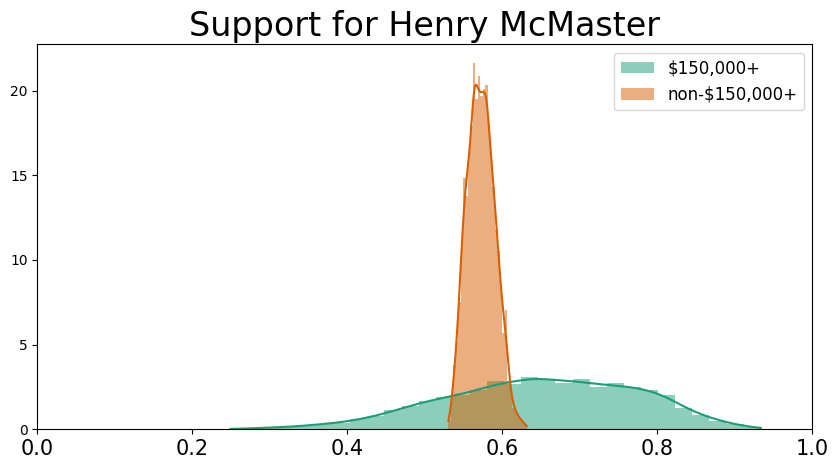

In [363]:
rep_150_more_ei_rural.plot_kde()

# Plot the ecological inference results



In [86]:
print(rep_white_ei)



In [372]:
import json

def extract_ei_data(ei_object):
    sampled_voting_prefs = ei_object.sampled_voting_prefs  # Numpy array or array-like
    group_names = ei_object.group_names_for_display()         # List of strings
    candidate_name = ei_object.candidate_name              # string

    output_data = {
        "data" : {
            "sampled_voting_prefs": sampled_voting_prefs,
        },
        "group_names": group_names,
        "candidate_names": candidate_name
    }
    return output_data


In [495]:
rep_white_ei_output_data = extract_ei_data(rep_white_ei)

rep_white_ei_rural_output_data = extract_ei_data(rep_white_ei_rural)
rep_white_ei_suburban_output_data = extract_ei_data(rep_white_ei_suburban)
rep_white_ei_urban_output_data = extract_ei_data(rep_white_ei_urban)

rep_black_ei_output_data = extract_ei_data(rep_black_ei)
rep_black_ei_output_data_rural = extract_ei_data(rep_black_ei_rural)
rep_black_ei_output_data_suburban = extract_ei_data(rep_black_ei_suburban)
rep_black_ei_output_data_urban = extract_ei_data(rep_black_ei_urban)

rep_asian_ei_output_data = extract_ei_data(rep_asian_ei)
rep_asian_ei_output_data_rural = extract_ei_data(rep_asian_ei_rural)
rep_asian_ei_output_data_suburban = extract_ei_data(rep_asian_ei_suburban)
rep_asian_ei_output_data_urban = extract_ei_data(rep_asian_ei_urban)

rep_hispanic_ei_output_data = extract_ei_data(rep_hispanic_ei)
rep_hispanic_ei_output_data_rural = extract_ei_data(rep_hispanic_ei_rural)
rep_hispanic_ei_output_data_suburban = extract_ei_data(rep_hispanic_ei_suburban)
rep_hispanic_ei_output_data_urban = extract_ei_data(rep_hispanic_ei_urban)

dem_white_ei_output_data = extract_ei_data(dem_white_ei)
dem_white_ei_output_data_rural = extract_ei_data(dem_white_ei_rural)
dem_white_ei_output_data_suburban = extract_ei_data(dem_white_ei_subrban)
dem_white_ei_output_data_urban = extract_ei_data(dem_white_ei_urban)

dem_black_ei_output_data = extract_ei_data(dem_black_ei)
dem_black_ei_output_data_rural = extract_ei_data(dem_black_ei_rural)
dem_black_ei_output_data_suburban = extract_ei_data(dem_black_ei_suburban)
dem_black_ei_output_data_urban = extract_ei_data(dem_black_ei_urban)

dem_asian_ei_output_data = extract_ei_data(dem_asian_ei)
dem_asian_ei_output_data_rural = extract_ei_data(dem_asian_ei_rural)
dem_asian_ei_output_data_suburban = extract_ei_data(dem_asian_ei_suburban)
dem_asian_ei_output_data_urban = extract_ei_data(dem_asian_ei_urban)


dem_hispanic_ei_output_data = extract_ei_data(dem_hispanic_ei)
dem_hispanic_ei_output_data_rural = extract_ei_data(dem_hispanic_ei_rural)
dem_hispanic_ei_output_data_suburban = extract_ei_data(dem_hispanic_ei_suburban)
dem_hispanic_ei_output_data_urban = extract_ei_data(dem_hispanic_ei_urban)


dem_0_35_ei_output_data = extract_ei_data(dem_0_35_ei)
dem_0_35_ei_rural_output_data = extract_ei_data(dem_0_35_ei_rural)
dem_0_35_ei_suburban_output_data = extract_ei_data(dem_0_35_ei_suburban)
dem_0_35_ei_urban_output_data = extract_ei_data(dem_0_35_ei_urban)

dem_35_60_ei_output_data = extract_ei_data(dem_35_60_ei)
dem_35_60_ei_rural_output_data = extract_ei_data(dem_35_60_ei_rural)
dem_35_60_ei_suburban_output_data = extract_ei_data(dem_35_60_ei_suburban)
dem_35_60_ei_urban_output_data = extract_ei_data(dem_35_60_ei_urban)


dem_60_100_ei_output_data = extract_ei_data(dem_60_100_ei)

dem_60_100_ei_rural_output_data = extract_ei_data(dem_60_100_ei_rural)

dem_60_100_ei_suburban_output_data = extract_ei_data(dem_60_100_ei_suburban)

dem_60_100_ei_urban_output_data = extract_ei_data(dem_60_100_ei_urban)


dem_100_125_ei_output_data = extract_ei_data(dem_100_125_ei)

dem_100_125_ei_rural_output_data = extract_ei_data(dem_100_125_ei_rural)

dem_100_125_ei_suburban_output_data = extract_ei_data(dem_100_125_ei_suburban)

dem_100_125_ei_urban_output_data = extract_ei_data(dem_100_125_ei_urban)

dem_125_150_ei_output_data = extract_ei_data(dem_125_150_ei)

dem_125_150_ei_rural_output_data = extract_ei_data(dem_125_150_ei_rural)

dem_125_150_ei_suburban_output_data = extract_ei_data(dem_125_150_ei_suburban)

dem_125_150_ei_urban_output_data = extract_ei_data(dem_125_150_ei_urban)

dem_150_more_ei_output_data = extract_ei_data(dem_150_more_ei)

dem_150_more_ei_rural_output_data = extract_ei_data(dem_150_more_ei_rural)

dem_150_more_ei_suburban_output_data = extract_ei_data(dem_150_more_ei_suburban)

dem_150_more_ei_urban_output_data = extract_ei_data(dem_150_more_ei_urban)

rep_0_35_ei_output_data = extract_ei_data(rep_0_35_ei)

rep_0_35_ei_rural_output_data = extract_ei_data(rep_0_35_ei_rural)

rep_0_35_ei_suburban_output_data = extract_ei_data(rep_0_35_ei_suburban)

rep_0_35_ei_urban_output_data = extract_ei_data(rep_0_35_ei_urban)

rep_35_60_ei_output_data = extract_ei_data(rep_35_60_ei)

rep_35_60_ei_rural_output_data = extract_ei_data(rep_35_60_ei_rural)

rep_35_60_ei_suburban_output_data = extract_ei_data(rep_35_60_ei_suburban)

rep_35_60_ei_urban_output_data = extract_ei_data(rep_35_60_ei_urban)

rep_60_100_ei_output_data = extract_ei_data(rep_60_100_ei)

rep_60_100_ei_rural_output_data = extract_ei_data(rep_60_100_ei_rural)

rep_60_100_ei_suburban_output_data = extract_ei_data(rep_60_100_ei_suburban)

rep_60_100_ei_urban_output_data = extract_ei_data(rep_60_100_ei_urban)

rep_100_125_ei_output_data = extract_ei_data(rep_100_125_ei)

rep_100_125_ei_rural_output_data = extract_ei_data(rep_100_125_ei_rural)

rep_100_125_ei_suburban_output_data = extract_ei_data(rep_100_125_ei_suburban)

rep_100_125_ei_urban_output_data = extract_ei_data(rep_100_125_ei_urban)

rep_125_150_ei_output_data = extract_ei_data(rep_125_150_ei)

rep_125_150_ei_rural_output_data = extract_ei_data(rep_125_150_ei_rural)

rep_125_150_ei_suburban_output_data = extract_ei_data(rep_125_150_ei_suburban)

rep_125_150_ei_urban_output_data = extract_ei_data(rep_125_150_ei_urban)

rep_150_more_ei_output_data = extract_ei_data(rep_150_more_ei)

rep_150_more_ei_rural_output_data = extract_ei_data(rep_150_more_ei_rural)

rep_150_more_ei_suburban_output_data = extract_ei_data(rep_150_more_ei_suburban)

rep_150_more_ei_urban_output_data = extract_ei_data(rep_150_more_ei_urban)


In [496]:
sc_output_json_racial = {
    "NAME": "South Carolina",
    "data": {
        "WHITE": {
            "REPUBLICAN": {
                "ALL": rep_white_ei_output_data,
                "RURAL": rep_white_ei_rural_output_data,
                "SUBURBAN": rep_white_ei_suburban_output_data,
                "URBAN": rep_white_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": dem_white_ei_output_data,
                "RURAL": dem_white_ei_output_data_rural,
                "SUBURBAN": dem_white_ei_output_data_suburban,
                "URBAN": dem_white_ei_output_data_urban
            }
        },
        "BLACK": {
            "REPUBLICAN": {
                "ALL": rep_black_ei_output_data,
                "RURAL": rep_black_ei_output_data_rural,
                "SUBURBAN": rep_black_ei_output_data_suburban,
                "URBAN": rep_black_ei_output_data_urban
            },
            "DEMOCRATIC": {
                "ALL": dem_black_ei_output_data,
                "RURAL": dem_black_ei_output_data_rural,
                "SUBURBAN": dem_black_ei_output_data_suburban,
                "URBAN": dem_black_ei_output_data_urban
            }
        },
        "ASIAN": {
            "REPUBLICAN": {
                "ALL": rep_asian_ei_output_data,
                "RURAL": rep_asian_ei_output_data_rural,
                "SUBURBAN": rep_asian_ei_output_data_suburban,
                "URBAN": rep_asian_ei_output_data_urban
            },
            "DEMOCRATIC": {
                "ALL": dem_asian_ei_output_data,
                "RURAL": dem_asian_ei_output_data_rural,
                "SUBURBAN": dem_asian_ei_output_data_suburban,
                "URBAN": dem_asian_ei_output_data_urban
            }
        },
        "HISPANIC": {
            "REPUBLICAN": {
                "ALL": rep_hispanic_ei_output_data,
                "RURAL": rep_hispanic_ei_output_data_rural,
                "SUBURBAN": rep_hispanic_ei_output_data_suburban,
                "URBAN": rep_hispanic_ei_output_data_urban
            },
            "DEMOCRATIC": {
                "ALL": dem_hispanic_ei_output_data,
                "RURAL": dem_hispanic_ei_output_data_rural,
                "SUBURBAN": dem_hispanic_ei_output_data_suburban,
                "URBAN": dem_hispanic_ei_output_data_urban
            }
        }
    }
}

In [497]:
sc_output_json_economic = {
    "NAME": "South Carolina",
    "data": {
        "0_35K": {
            "REPUBLICAN": {
                "ALL": rep_0_35_ei_output_data,
                "RURAL": rep_0_35_ei_rural_output_data,
                "SUBURBAN": rep_0_35_ei_suburban_output_data,
                "URBAN": rep_0_35_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": dem_0_35_ei_output_data,
                "RURAL": dem_0_35_ei_rural_output_data,
                "SUBURBAN": dem_0_35_ei_suburban_output_data,
                "URBAN": dem_0_35_ei_urban_output_data
            }
        },
        "35K_60K": {
            "REPUBLICAN": {
                "ALL": rep_35_60_ei_output_data,
                "RURAL": rep_35_60_ei_rural_output_data,
                "SUBURBAN": rep_35_60_ei_suburban_output_data,
                "URBAN": rep_35_60_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": dem_35_60_ei_output_data,
                "RURAL": dem_35_60_ei_rural_output_data,
                "SUBURBAN": dem_35_60_ei_suburban_output_data,
                "URBAN": dem_35_60_ei_urban_output_data
            }
        },
        "60K_100K": {
            "REPUBLICAN": {
                "ALL": rep_60_100_ei_output_data,
                "RURAL": rep_60_100_ei_rural_output_data,
                "SUBURBAN": rep_60_100_ei_suburban_output_data,
                "URBAN": rep_60_100_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": dem_60_100_ei_output_data,
                "RURAL": dem_60_100_ei_rural_output_data,
                "SUBURBAN": dem_60_100_ei_suburban_output_data,
                "URBAN": dem_60_100_ei_urban_output_data
            }
        },
        "100K_125K": {
            "REPUBLICAN": {
                "ALL": rep_100_125_ei_output_data,
                "RURAL": rep_100_125_ei_rural_output_data,
                "SUBURBAN": rep_100_125_ei_suburban_output_data,
                "URBAN": rep_100_125_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": dem_100_125_ei_output_data,
                "RURAL": dem_100_125_ei_rural_output_data,
                "SUBURBAN": dem_100_125_ei_suburban_output_data,
                "URBAN": dem_100_125_ei_urban_output_data
            }
        },
        "125K_150K": {
            "REPUBLICAN": {
                "ALL": rep_125_150_ei_output_data,
                "RURAL": rep_125_150_ei_rural_output_data,
                "SUBURBAN": rep_125_150_ei_suburban_output_data,
                "URBAN": rep_125_150_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": dem_125_150_ei_output_data,
                "RURAL": dem_125_150_ei_rural_output_data,
                "SUBURBAN": dem_125_150_ei_suburban_output_data,
                "URBAN": dem_125_150_ei_urban_output_data
            }
        },
        "150K_MORE": {
            "REPUBLICAN": {
                "ALL": rep_150_more_ei_output_data,
                "RURAL": rep_150_more_ei_rural_output_data,
                "SUBURBAN": rep_150_more_ei_suburban_output_data,
                "URBAN": rep_150_more_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": dem_150_more_ei_output_data,
                "RURAL": dem_150_more_ei_rural_output_data,
                "SUBURBAN": dem_150_more_ei_suburban_output_data,
                "URBAN": dem_150_more_ei_urban_output_data
            }
        }
    }
}

In [498]:
sc_json_output = json.dumps(sc_output_json_racial , indent=4, cls=json_serialize)
with open("states/south_carolina/ecological_inference/ecological_inference.json", "w") as f:
    f.write(sc_json_output)

In [499]:
sc_json_econ_output = json.dumps(sc_output_json_economic , indent=4, cls=json_serialize)
with open("states/south_carolina/ecological_inference/ecological_inference_economic.json", "w") as f:
    f.write(sc_json_econ_output)

In [222]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# If not already defined, ensure any constants or helper functions 
# (e.g., colors, FIGSIZE, FONTSIZE, TITLESIZE, size_ticks) are defined or imported here.

with open("processed_individual/pyei_test/rep_white_ei_data.json", "r") as f:
    rep_white_data = json.load(f)

# Extract data
sampled_voting_prefs = np.array(rep_white_data["data"]["sampled_voting_prefs"])
# sampled_voting_prefs = sampled_voting_prefs[:, :, np.newaxis]
group_names = rep_white_data["group_names"]
candidate_names = rep_white_data["candidate_names"]



In [223]:
num_groups = sampled_voting_prefs.shape
num_groups = num_groups[0]


In [224]:
print("Number of groups:", len(group_names))
print("Number of candidates:", type(candidate_names))


Number of groups: 2
Number of candidates: <class 'str'>


In [227]:
def plot_kdes_simple(sampled_prefs, group_names, candidate_names):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Ensure candidate_names is a list
    if isinstance(candidate_names, str):
        candidate_names = [candidate_names]

    sampled_prefs = np.array(sampled_prefs)
    num_groups = sampled_prefs.shape[0]

    # Check that group_names matches the data dimension
    if len(group_names) != num_groups:
        print("Warning: The number of group_names does not match the number of groups in sampled_prefs.")
        group_names = group_names[:num_groups]

    colors = ["red", "blue"]
    # if len(colors) < num_groups:
    #     raise ValueError("Not enough colors defined for the number of groups.")

    fig, ax = plt.subplots(figsize=(8, 4))

    for i in range(num_groups):
        sns.histplot(
            sampled_prefs[i, :],
            kde=True,
            stat="density",
            element="step",
            ax=ax,
            label=group_names[i],
            color=colors[i]
        )

    ax.set_title(f"Support for {candidate_names[0]}", fontsize=14)
    ax.set_xlabel("Preference")
    ax.set_ylabel("Density")
    ax.set_xlim((0, 1))
    ax.legend()

    plt.tight_layout()
    plt.show()
    return ax


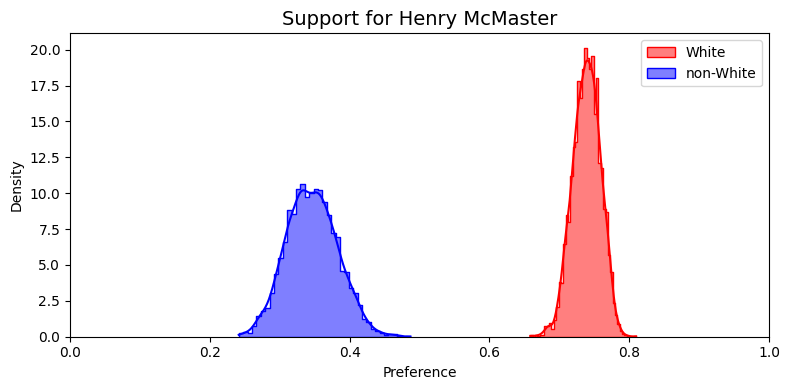

<Axes: title={'center': 'Support for Henry McMaster'}, xlabel='Preference', ylabel='Density'>

In [228]:
# Now re-plot using the previously defined plot_kdes function
plot_kdes_simple(sampled_voting_prefs, group_names, candidate_names)

### Export data

## Maryland

In [501]:
md_election_gov_df = pd.read_json('states/maryland/election/md_election_gov_22.json')
md_race_df = pd.read_json('states/maryland/demographics/maryland_precincts_racial_population.json')
md_economic_df = pd.read_json('states/maryland/economic/maryland_precincts_household_income.json')
md_region_type_df = pd.read_json('states/maryland/geodata/maryland_precincts_region_type.json')

In [502]:
md_candidate_mapping = {
    "DEMOCRATIC": "Wes Moore (Democratic Party)",
    "REPUBLICAN": "Dan Cox (Republican Party)"
}

### Preprocess data

#### Racial Group

In [503]:
columns_to_keep = ['UNIQUE_ID', 'TOT_POP22']

In [504]:
md_race_with_percentages = calculate_population_distribution(md_race_df, race_columns, columns_to_keep)

In [505]:
columns_to_keep = ['UNIQUE_ID', 'TOT_VOT']

In [506]:
md_election_gov_with_percentages = calculate_voting_distribution(md_election_gov_df, election_columns, columns_to_keep)

In [507]:
md_race_merged_ei_df = pd.merge(md_election_gov_with_percentages, md_race_with_percentages, on='UNIQUE_ID', how='left')

In [508]:
md_race_merged_ei_df.fillna(0, inplace=True)

In [509]:
md_race_merged_ei_df = md_race_merged_ei_df.drop(columns=['TOT_POP22'])
md_region_type_df = md_region_type_df.drop(columns=['TOT_POP22'])

In [510]:
md_race_merged_ei_df = pd.merge(md_race_merged_ei_df, md_region_type_df, on='UNIQUE_ID', how='left')

In [511]:
md_race_merged_ei_rural_df = md_race_merged_ei_df[md_race_merged_ei_df['region_type'] == 'rural']

md_race_merged_ei_suburban_df = md_race_merged_ei_df[md_race_merged_ei_df['region_type'] == 'suburban']

md_race_merged_ei_urban_df = md_race_merged_ei_df[md_race_merged_ei_df['region_type'] == 'urban']

In [512]:
md_race_merged_ei_df = md_race_merged_ei_df[md_race_merged_ei_df['TOT_VOT']>0]

md_race_merged_ei_rural_df = md_race_merged_ei_rural_df[md_race_merged_ei_rural_df['TOT_VOT']>0]

md_race_merged_ei_suburban_df = md_race_merged_ei_suburban_df[md_race_merged_ei_suburban_df['TOT_VOT']>0]

md_race_merged_ei_urban_df = md_race_merged_ei_urban_df[md_race_merged_ei_urban_df['TOT_VOT']>0]

In [513]:
md_race_merged_ei_df = md_race_merged_ei_df.sample(n=100, random_state=42)

md_race_merged_ei_rural_df = md_race_merged_ei_rural_df.sample(n=100, random_state=42)

md_race_merged_ei_suburban_df = md_race_merged_ei_suburban_df.sample(n=100, random_state=42)

md_race_merged_ei_urban_df = md_race_merged_ei_urban_df.sample(n=100, random_state=42)

#### Economic Group

In [514]:
columns_to_keep = ['UNIQUE_ID']

In [515]:
md_economic_with_percentages = calculate_income_distribution(md_economic_df, income_columns, columns_to_keep)

In [516]:
md_economic_merged_ei_df = pd.merge(md_election_gov_with_percentages, md_economic_with_percentages, on='UNIQUE_ID', how='left')

In [517]:
md_economic_merged_ei_df.fillna(0, inplace=True)

In [518]:
md_economic_merged_ei_df = pd.merge(md_economic_merged_ei_df, md_region_type_df, on='UNIQUE_ID', how='left')

In [519]:
md_economic_merged_ei_rural_df = md_economic_merged_ei_df[md_economic_merged_ei_df['region_type'] == 'rural']

md_economic_merged_ei_suburban_df = md_economic_merged_ei_df[md_economic_merged_ei_df['region_type'] == 'suburban']

md_economic_merged_ei_urban_df = md_economic_merged_ei_df[md_economic_merged_ei_df['region_type'] == 'urban']

In [520]:
md__merged_ei_df = md_economic_merged_ei_df[md_economic_merged_ei_df['TOT_VOT']>0]

md_economic_merged_ei_rural_df = md_economic_merged_ei_rural_df[md_economic_merged_ei_rural_df['TOT_VOT']>0]

md_economic_merged_ei_suburban_df = md_economic_merged_ei_suburban_df[md_economic_merged_ei_suburban_df['TOT_VOT']>0]

md_economic_merged_ei_urban_df = md_economic_merged_ei_urban_df[md_economic_merged_ei_urban_df['TOT_VOT']>0]

In [521]:
md_economic_merged_ei_df = md_economic_merged_ei_df.sample(n=100, random_state=42)

md_economic_merged_ei_rural_df = md_economic_merged_ei_rural_df.sample(n=100, random_state=42)

md_economic_merged_ei_suburban_df = md_economic_merged_ei_suburban_df.sample(n=100, random_state=42)

md_economic_merged_ei_urban_df = md_economic_merged_ei_urban_df.sample(n=100, random_state=42)

### Running EI models

#### Racial Run

##### DEMOCRATIC Run

In [522]:
md_dem_white_ei, md_dem_white_summary = run_ecological_inference(
    df=md_race_merged_ei_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:03.504361
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.363844
Transforming variables...
Transformation time = 0:00:29.565087


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Wes Moore (Democratic Party) is
        0.577
        The posterior mean for the district-level voting preference of
        non-White for Wes Moore (Democratic Party) is
        0.860
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Wes Moore (Democratic Party) is
        [0.53852622 0.61716294]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Wes Moore (Democratic Party) is
        [0.80744494 0.90527361]
        


In [523]:
md_dem_white_ei_rural, md_dem_white_summary_rural = run_ecological_inference(
    df=md_race_merged_ei_rural_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:02.905026
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.453957
Transforming variables...
Transformation time = 0:00:16.170225


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Wes Moore (Democratic Party) is
        0.537
        The posterior mean for the district-level voting preference of
        non-White for Wes Moore (Democratic Party) is
        0.846
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Wes Moore (Democratic Party) is
        [0.49951781 0.57381741]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Wes Moore (Democratic Party) is
        [0.79837251 0.88571898]
        


In [524]:
md_dem_white_ei_subrban, md_dem_white_summary_suburban = run_ecological_inference(
    df=md_race_merged_ei_suburban_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.315620
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.470483
Transforming variables...
Transformation time = 0:00:44.332134


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Wes Moore (Democratic Party) is
        0.510
        The posterior mean for the district-level voting preference of
        non-White for Wes Moore (Democratic Party) is
        0.955
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Wes Moore (Democratic Party) is
        [0.49361638 0.53232986]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Wes Moore (Democratic Party) is
        [0.90907052 0.98416509]
        


In [525]:
md_dem_white_ei_urban, md_dem_white_summary_urban = run_ecological_inference(
    df=md_race_merged_ei_urban_df,
    demographic_col="WHITE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:06.307946
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.203758
Transforming variables...
Transformation time = 0:00:40.931836


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Wes Moore (Democratic Party) is
        0.469
        The posterior mean for the district-level voting preference of
        non-White for Wes Moore (Democratic Party) is
        0.957
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Wes Moore (Democratic Party) is
        [0.43897194 0.50240938]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Wes Moore (Democratic Party) is
        [0.93223608 0.97583089]
        


In [526]:
md_dem_black_ei, md_dem_black_summary = run_ecological_inference(
    df=md_race_merged_ei_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.523514
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.456666
Transforming variables...
Transformation time = 0:00:32.651424


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Wes Moore (Democratic Party) is
        0.962
        The posterior mean for the district-level voting preference of
        non-Black for Wes Moore (Democratic Party) is
        0.628
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Wes Moore (Democratic Party) is
        [0.91656875 0.99044277]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Wes Moore (Democratic Party) is
        [0.61746936 0.64064843]
        


In [527]:
md_dem_black_ei_rural, md_dem_black_summary_rural = run_ecological_inference(
    df=md_race_merged_ei_rural_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.300995
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.017034
Transforming variables...
Transformation time = 0:00:16.042481


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Wes Moore (Democratic Party) is
        0.947
        The posterior mean for the district-level voting preference of
        non-Black for Wes Moore (Democratic Party) is
        0.620
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Wes Moore (Democratic Party) is
        [0.8939008  0.97648774]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Wes Moore (Democratic Party) is
        [0.60840408 0.63442742]
        


In [602]:
md_dem_black_ei_suburban, md_dem_black_summary_suburban = run_ecological_inference(
    df=md_race_merged_ei_suburban_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.459708
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.557858
Transforming variables...
Transformation time = 0:00:52.940994


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Wes Moore (Democratic Party) is
        0.984
        The posterior mean for the district-level voting preference of
        non-Black for Wes Moore (Democratic Party) is
        0.585
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Wes Moore (Democratic Party) is
        [0.94880359 0.99894976]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Wes Moore (Democratic Party) is
        [0.57899045 0.59351425]
        


In [529]:
md_dem_black_ei_urban, md_dem_black_summary_urban = run_ecological_inference(
    df=md_race_merged_ei_urban_df,
    demographic_col="BLACK_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.528156
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.107581
Transforming variables...
Transformation time = 0:01:00.090991


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Wes Moore (Democratic Party) is
        0.984
        The posterior mean for the district-level voting preference of
        non-Black for Wes Moore (Democratic Party) is
        0.622
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Wes Moore (Democratic Party) is
        [0.95921311 0.9976493 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Wes Moore (Democratic Party) is
        [0.61284355 0.63572651]
        


In [530]:
md_dem_asian_ei, md_dem_asian_summary = run_ecological_inference(
    df=md_race_merged_ei_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.330453
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:06.027483
Transforming variables...
Transformation time = 0:00:25.921405


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Wes Moore (Democratic Party) is
        0.819
        The posterior mean for the district-level voting preference of
        non-Asian for Wes Moore (Democratic Party) is
        0.679
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Wes Moore (Democratic Party) is
        [0.60601587 0.98335937]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Wes Moore (Democratic Party) is
        [0.65462035 0.70599542]
        


In [531]:
md_dem_asian_ei_rural, md_dem_asian_summary_rural = run_ecological_inference(
    df=md_race_merged_ei_rural_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.230659
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.062538
Transforming variables...
Transformation time = 0:00:11.728382


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Wes Moore (Democratic Party) is
        0.651
        The posterior mean for the district-level voting preference of
        non-Asian for Wes Moore (Democratic Party) is
        0.670
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Wes Moore (Democratic Party) is
        [0.36331097 0.93720986]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Wes Moore (Democratic Party) is
        [0.64932977 0.68957405]
        


In [532]:
md_dem_asian_ei_suburban, md_dem_asian_summary_suburban = run_ecological_inference(
    df=md_race_merged_ei_suburban_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.261373
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.077350
Transforming variables...
Transformation time = 0:00:17.589524


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Wes Moore (Democratic Party) is
        0.603
        The posterior mean for the district-level voting preference of
        non-Asian for Wes Moore (Democratic Party) is
        0.652
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Wes Moore (Democratic Party) is
        [0.33070562 0.92082341]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Wes Moore (Democratic Party) is
        [0.62435154 0.67552786]
        


In [533]:
md_dem_asian_ei_urban, md_dem_asian_summary_urban = run_ecological_inference(
    df=md_race_merged_ei_urban_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.524486
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.161076
Transforming variables...
Transformation time = 0:00:20.050417


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Wes Moore (Democratic Party) is
        0.546
        The posterior mean for the district-level voting preference of
        non-Asian for Wes Moore (Democratic Party) is
        0.745
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Wes Moore (Democratic Party) is
        [0.33501431 0.90787865]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Wes Moore (Democratic Party) is
        [0.70784015 0.76498381]
        


In [534]:
md_dem_hispanic_ei, md_rep_asian_summary = run_ecological_inference(
    df=md_race_merged_ei_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:30.917155
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.903008
Transforming variables...
Transformation time = 0:00:54.271510


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Wes Moore (Democratic Party) is
        0.917
        The posterior mean for the district-level voting preference of
        non-Hispanic for Wes Moore (Democratic Party) is
        0.673
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Wes Moore (Democratic Party) is
        [0.76379163 0.99828662]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Wes Moore (Democratic Party) is
        [0.66388551 0.68783795]
        


In [535]:
md_dem_hispanic_ei_rural, md_rep_asian_summary_rural = run_ecological_inference(
    df=md_race_merged_ei_rural_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.290346
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.262049
Transforming variables...
Transformation time = 0:00:19.555084


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Wes Moore (Democratic Party) is
        0.884
        The posterior mean for the district-level voting preference of
        non-Hispanic for Wes Moore (Democratic Party) is
        0.656
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Wes Moore (Democratic Party) is
        [0.71304626 0.98608722]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Wes Moore (Democratic Party) is
        [0.64724518 0.66950392]
        


In [536]:
md_dem_hispanic_ei_suburban, md_rep_asian_summary_suburban = run_ecological_inference(
    df=md_race_merged_ei_suburban_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:04.644894
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.129494
Transforming variables...
Transformation time = 0:00:17.929778


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Wes Moore (Democratic Party) is
        0.796
        The posterior mean for the district-level voting preference of
        non-Hispanic for Wes Moore (Democratic Party) is
        0.634
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Wes Moore (Democratic Party) is
        [0.61743266 0.94599438]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Wes Moore (Democratic Party) is
        [0.62171189 0.64875634]
        


In [537]:
md_dem_hispanic_ei_urban, md_rep_asian_summary_urban = run_ecological_inference(
    df=md_race_merged_ei_urban_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.534185
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.164471
Transforming variables...
Transformation time = 0:00:45.673092


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Wes Moore (Democratic Party) is
        0.926
        The posterior mean for the district-level voting preference of
        non-Hispanic for Wes Moore (Democratic Party) is
        0.698
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Wes Moore (Democratic Party) is
        [0.78938227 0.99856919]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Wes Moore (Democratic Party) is
        [0.68510094 0.72081749]
        


##### Running Repulican

In [538]:
md_rep_white_ei, md_rep_white_summary = run_ecological_inference(
    df=md_race_merged_ei_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.501906
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.009261
Transforming variables...
Transformation time = 0:00:31.708351


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Dan Cox (Republican Party) is
        0.421
        The posterior mean for the district-level voting preference of
        non-White for Dan Cox (Republican Party) is
        0.142
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Dan Cox (Republican Party) is
        [0.37932472 0.45927309]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Dan Cox (Republican Party) is
        [0.09771881 0.1936028 ]
        


In [539]:
md_rep_white_ei_rural, md_rep_white_summary_rural = run_ecological_inference(
    df=md_race_merged_ei_rural_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.302629
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.259815
Transforming variables...
Transformation time = 0:00:18.973912


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Dan Cox (Republican Party) is
        0.464
        The posterior mean for the district-level voting preference of
        non-White for Dan Cox (Republican Party) is
        0.153
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Dan Cox (Republican Party) is
        [0.42781337 0.49951208]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Dan Cox (Republican Party) is
        [0.11255046 0.19869804]
        


In [540]:
md_rep_white_ei_suburban, md_rep_white_summary_suburban = run_ecological_inference(
    df=md_race_merged_ei_suburban_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.375629
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.393344
Transforming variables...
Transformation time = 0:00:58.955070


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Dan Cox (Republican Party) is
        0.490
        The posterior mean for the district-level voting preference of
        non-White for Dan Cox (Republican Party) is
        0.045
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Dan Cox (Republican Party) is
        [0.46866606 0.50665289]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Dan Cox (Republican Party) is
        [0.01409183 0.08969558]
        


In [541]:
md_rep_white_ei_urban, md_rep_white_summary_urban= run_ecological_inference(
    df=md_race_merged_ei_urban_df,
    demographic_col="WHITE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="White",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:08.117907
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.681546
Transforming variables...
Transformation time = 0:00:45.633776


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        White for Dan Cox (Republican Party) is
        0.529
        The posterior mean for the district-level voting preference of
        non-White for Dan Cox (Republican Party) is
        0.044
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        White for Dan Cox (Republican Party) is
        [0.49483389 0.55996615]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-White for Dan Cox (Republican Party) is
        [0.02423429 0.06855534]
        


In [542]:
md_rep_black_ei, md_rep_black_summary = run_ecological_inference(
    df=md_race_merged_ei_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.457784
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.204883
Transforming variables...
Transformation time = 0:00:46.897696


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Dan Cox (Republican Party) is
        0.042
        The posterior mean for the district-level voting preference of
        non-Black for Dan Cox (Republican Party) is
        0.371
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Dan Cox (Republican Party) is
        [0.01342772 0.08703972]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Dan Cox (Republican Party) is
        [0.35777462 0.38098058]
        


In [543]:
md_rep_black_ei_rural, md_rep_black_summary_rural = run_ecological_inference(
    df=md_race_merged_ei_rural_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.573818
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.843826
Transforming variables...
Transformation time = 0:00:18.618754


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Dan Cox (Republican Party) is
        0.051
        The posterior mean for the district-level voting preference of
        non-Black for Dan Cox (Republican Party) is
        0.379
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Dan Cox (Republican Party) is
        [0.02264736 0.09540243]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Dan Cox (Republican Party) is
        [0.3662628  0.39131049]
        


In [544]:
md_rep_black_ei_suburban, md_rep_black_summary_suburban = run_ecological_inference(
    df=md_race_merged_ei_suburban_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.293767
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.303482
Transforming variables...
Transformation time = 0:01:05.768412


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Dan Cox (Republican Party) is
        0.019
        The posterior mean for the district-level voting preference of
        non-Black for Dan Cox (Republican Party) is
        0.415
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Dan Cox (Republican Party) is
        [0.00149679 0.06199323]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Dan Cox (Republican Party) is
        [0.40441877 0.42063397]
        


In [545]:
md_rep_black_ei_urban, md_rep_black_summary_urban = run_ecological_inference(
    df=md_race_merged_ei_urban_df,
    demographic_col="BLACK_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Black",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.794446
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.201953
Transforming variables...
Transformation time = 0:01:13.850780


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Black for Dan Cox (Republican Party) is
        0.008
        The posterior mean for the district-level voting preference of
        non-Black for Dan Cox (Republican Party) is
        0.382
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Black for Dan Cox (Republican Party) is
        [0.00054349 0.03015418]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Black for Dan Cox (Republican Party) is
        [0.37170709 0.38893074]
        


In [546]:
md_rep_asian_ei, md_rep_asian_summary = run_ecological_inference(
    df=md_race_merged_ei_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.474098
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.863569
Transforming variables...
Transformation time = 0:00:50.101619


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Dan Cox (Republican Party) is
        0.191
        The posterior mean for the district-level voting preference of
        non-Asian for Dan Cox (Republican Party) is
        0.320
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Dan Cox (Republican Party) is
        [0.01569142 0.38307258]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Dan Cox (Republican Party) is
        [0.29526563 0.3452535 ]
        


In [547]:
md_rep_asian_ei_rural, md_rep_asian_summary_rural = run_ecological_inference(
    df=md_race_merged_ei_rural_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:07.879049
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.789201
Transforming variables...
Transformation time = 0:00:11.999995


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Dan Cox (Republican Party) is
        0.390
        The posterior mean for the district-level voting preference of
        non-Asian for Dan Cox (Republican Party) is
        0.327
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Dan Cox (Republican Party) is
        [0.11892497 0.64365138]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Dan Cox (Republican Party) is
        [0.30967211 0.34677603]
        


In [548]:
md_rep_asian_ei_suburban, md_rep_asian_summary_suburban = run_ecological_inference(
    df=md_race_merged_ei_suburban_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.919301
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.933809
Transforming variables...
Transformation time = 0:00:21.902440


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Dan Cox (Republican Party) is
        0.365
        The posterior mean for the district-level voting preference of
        non-Asian for Dan Cox (Republican Party) is
        0.351
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Dan Cox (Republican Party) is
        [0.1225927  0.64617722]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Dan Cox (Republican Party) is
        [0.32665287 0.37209187]
        


In [549]:
md_rep_asian_ei_urban, md_rep_asian_summary_urban = run_ecological_inference(
    df=md_race_merged_ei_urban_df,
    demographic_col="ASIAN_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Asian",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:02.156708
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.138748
Transforming variables...
Transformation time = 0:00:23.007152


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Asian for Dan Cox (Republican Party) is
        0.455
        The posterior mean for the district-level voting preference of
        non-Asian for Dan Cox (Republican Party) is
        0.255
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Asian for Dan Cox (Republican Party) is
        [0.17139778 0.66849602]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Asian for Dan Cox (Republican Party) is
        [0.2340761 0.2839371]
        


In [550]:
md_rep_hispanic_ei, md_rep_hispanic_summary = run_ecological_inference(
    df=md_race_merged_ei_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...


Compilation time = 0:00:01.507919
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.289090
Transforming variables...
Transformation time = 0:00:53.110220


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Dan Cox (Republican Party) is
        0.074
        The posterior mean for the district-level voting preference of
        non-Hispanic for Dan Cox (Republican Party) is
        0.328
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Dan Cox (Republican Party) is
        [0.00407003 0.22206635]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Dan Cox (Republican Party) is
        [0.31279834 0.33591591]
        


In [551]:
md_rep_hispanic_ei_rural, md_rep_hispanic_summary_rural = run_ecological_inference(
    df=md_race_merged_ei_rural_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.274690
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.218193
Transforming variables...
Transformation time = 0:00:41.314071


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Dan Cox (Republican Party) is
        0.136
        The posterior mean for the district-level voting preference of
        non-Hispanic for Dan Cox (Republican Party) is
        0.342
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Dan Cox (Republican Party) is
        [0.02884046 0.30521827]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Dan Cox (Republican Party) is
        [0.32947634 0.35142106]
        


In [552]:
md_rep_hispanic_ei_suburban, md_rep_hispanic_summary_suburban = run_ecological_inference(
    df=md_race_merged_ei_suburban_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.710552
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.870967
Transforming variables...
Transformation time = 0:00:25.587499


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Dan Cox (Republican Party) is
        0.184
        The posterior mean for the district-level voting preference of
        non-Hispanic for Dan Cox (Republican Party) is
        0.367
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Dan Cox (Republican Party) is
        [0.03595325 0.38521712]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Dan Cox (Republican Party) is
        [0.35106093 0.37972629]
        


In [553]:
md_rep_hispanic_ei_urban, md_rep_hispanic_summary_urban = run_ecological_inference(
    df=md_race_merged_ei_urban_df,
    demographic_col="HISPANIC_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="Hispanic",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:07.412336
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.539296
Transforming variables...
Transformation time = 0:01:06.932204


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        Hispanic for Dan Cox (Republican Party) is
        0.114
        The posterior mean for the district-level voting preference of
        non-Hispanic for Dan Cox (Republican Party) is
        0.295
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        Hispanic for Dan Cox (Republican Party) is
        [0.01673368 0.25582913]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-Hispanic for Dan Cox (Republican Party) is
        [0.27281891 0.31123147]
        


#### Econ Run

##### Dem Run

In [554]:
md_dem_0_35_ei, md_dem_0_35_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.596844
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.525066
Transforming variables...
Transformation time = 0:00:45.348431


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Wes Moore (Democratic Party) is
        0.910
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Wes Moore (Democratic Party) is
        0.620
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Wes Moore (Democratic Party) is
        [0.81279094 0.97162749]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Wes Moore (Democratic Party) is
        [0.60968968 0.63589659]
        


In [555]:
md_dem_0_35_ei_rural, md_dem_0_35_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.670573
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:03.620986
Transforming variables...
Transformation time = 0:00:38.371518


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Wes Moore (Democratic Party) is
        0.903
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Wes Moore (Democratic Party) is
        0.635
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Wes Moore (Democratic Party) is
        [0.78810987 0.98195294]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Wes Moore (Democratic Party) is
        [0.62192162 0.6561082 ]
        


In [556]:
md_dem_0_35_ei_suburban, md_dem_0_35_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.481086
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.249869
Transforming variables...
Transformation time = 0:00:24.294531


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Wes Moore (Democratic Party) is
        0.846
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Wes Moore (Democratic Party) is
        0.614
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Wes Moore (Democratic Party) is
        [0.70099288 0.95050615]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Wes Moore (Democratic Party) is
        [0.59799159 0.63434661]
        


In [557]:
md_dem_0_35_ei_urban, md_dem_0_35_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="0_35K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.550241
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.268263
Transforming variables...
Transformation time = 0:00:25.550355


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Wes Moore (Democratic Party) is
        0.790
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Wes Moore (Democratic Party) is
        0.713
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Wes Moore (Democratic Party) is
        [0.63822739 0.93298393]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Wes Moore (Democratic Party) is
        [0.69131603 0.73574561]
        


In [558]:
md_dem_35_60_ei, md_dem_35_60_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:05.634822
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.975715
Transforming variables...
Transformation time = 0:00:46.580367


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        0.960
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        0.620
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.88459722 0.99526422]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.61400526 0.63084268]
        


In [559]:
md_dem_35_60_ei_rural, md_dem_35_60_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.529218
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.291235
Transforming variables...
Transformation time = 0:00:20.351854


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        0.902
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        0.640
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.78765936 0.97751669]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.63025226 0.65356351]
        


In [560]:
md_dem_35_60_ei_suburban, md_dem_35_60_summary_rural_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.435329
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.246296
Transforming variables...
Transformation time = 0:00:23.448217


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        0.846
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        0.616
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.68080475 0.9647417 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.60152074 0.63663976]
        


In [561]:
md_dem_35_60_ei_urban, md_dem_35_60_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.596646
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.328027
Transforming variables...
Transformation time = 0:00:36.204202


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        0.885
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        0.702
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.71799302 0.98351361]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.68836059 0.72404106]
        


In [562]:
md_dem_60_100_ei, md_dem_60_100_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.288175
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.173739
Transforming variables...
Transformation time = 0:00:43.734334


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        0.885
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        0.614
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.75552701 0.97739682]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.5939256  0.63984417]
        


In [563]:
md_dem_60_100_ei_rural, md_dem_60_100_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...


Compilation time = 0:00:01.341223
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.504769
Transforming variables...
Transformation time = 0:00:29.003394


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        0.917
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        0.627
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.80576824 0.98782138]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.61357592 0.64659252]
        


In [564]:
md_dem_60_100_ei_suburban, md_dem_60_100_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:05.482766
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.290494
Transforming variables...
Transformation time = 0:00:24.684051


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        0.812
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        0.603
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.65879448 0.94714471]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.57208889 0.63739   ]
        


In [565]:
md_dem_60_100_ei_urban, md_dem_60_100_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.670998
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.005076
Transforming variables...
Transformation time = 0:00:38.356779


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        0.879
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        0.686
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.7203602  0.97301886]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Wes Moore (Democratic Party) is
        [0.66240681 0.7260407 ]
        


In [566]:
md_dem_100_125_ei, md_dem_100_125_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.948548
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.920400
Transforming variables...
Transformation time = 0:00:17.319575


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Wes Moore (Democratic Party) is
        0.755
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Wes Moore (Democratic Party) is
        0.647
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Wes Moore (Democratic Party) is
        [0.53096192 0.96323742]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Wes Moore (Democratic Party) is
        [0.62318792 0.67193838]
        


In [567]:
md_dem_100_125_ei_rural, md_dem_100_125_summar_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.422766
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.014591
Transforming variables...
Transformation time = 0:00:43.016935


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Wes Moore (Democratic Party) is
        0.785
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Wes Moore (Democratic Party) is
        0.655
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Wes Moore (Democratic Party) is
        [0.5650451  0.98172153]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Wes Moore (Democratic Party) is
        [0.63582989 0.67533753]
        


In [568]:
md_dem_100_125_ei_suburban, md_dem_100_125_summar_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.276551
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.940829
Transforming variables...
Transformation time = 0:00:43.060903


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Wes Moore (Democratic Party) is
        0.778
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Wes Moore (Democratic Party) is
        0.626
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Wes Moore (Democratic Party) is
        [0.55898557 0.98808459]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Wes Moore (Democratic Party) is
        [0.60127092 0.65206179]
        


In [569]:
md_dem_100_125_ei_urban, md_dem_100_125_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:05.789356
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.146668
Transforming variables...
Transformation time = 0:00:20.156543


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Wes Moore (Democratic Party) is
        0.796
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Wes Moore (Democratic Party) is
        0.715
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Wes Moore (Democratic Party) is
        [0.6018515  0.96292529]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Wes Moore (Democratic Party) is
        [0.69212604 0.74017847]
        


In [570]:
md_dem_125_150_ei, md_dem_125_150_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.350854
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.356660
Transforming variables...
Transformation time = 0:00:21.086588


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Wes Moore (Democratic Party) is
        0.750
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Wes Moore (Democratic Party) is
        0.648
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Wes Moore (Democratic Party) is
        [0.49705647 0.94457172]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Wes Moore (Democratic Party) is
        [0.62973746 0.67079391]
        


In [571]:
md_dem_125_150_ei_rural, md_dem_125_150_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.508428
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.730011
Transforming variables...
Transformation time = 0:00:10.270500


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Wes Moore (Democratic Party) is
        0.684
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Wes Moore (Democratic Party) is
        0.663
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Wes Moore (Democratic Party) is
        [0.44490902 0.87880816]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Wes Moore (Democratic Party) is
        [0.64323902 0.68504644]
        


In [572]:
md_dem_125_150_ei_suburban, md_dem_125_150_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.433016
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.999560
Transforming variables...
Transformation time = 0:00:13.694568


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Wes Moore (Democratic Party) is
        0.771
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Wes Moore (Democratic Party) is
        0.630
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Wes Moore (Democratic Party) is
        [0.49222239 0.96819563]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Wes Moore (Democratic Party) is
        [0.61125468 0.65602179]
        


In [573]:
md_dem_125_150_ei_urban, md_dem_125_150_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.565945
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.087420
Transforming variables...
Transformation time = 0:00:19.779033


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Wes Moore (Democratic Party) is
        0.601
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Wes Moore (Democratic Party) is
        0.736
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Wes Moore (Democratic Party) is
        [0.37564333 0.90310887]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Wes Moore (Democratic Party) is
        [0.70603764 0.75852391]
        


In [574]:
md_dem_150_more_ei, md_dem_150_more_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.289627
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.079692
Transforming variables...
Transformation time = 0:00:29.997901


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Wes Moore (Democratic Party) is
        0.711
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Wes Moore (Democratic Party) is
        0.636
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Wes Moore (Democratic Party) is
        [0.62059983 0.80070894]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Wes Moore (Democratic Party) is
        [0.5832754  0.68689264]
        


In [575]:
md_dem_150_more_ei_rural, md_dem_150_more_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:05.718960
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.159918
Transforming variables...
Transformation time = 0:00:17.445256


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Wes Moore (Democratic Party) is
        0.627
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Wes Moore (Democratic Party) is
        0.686
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Wes Moore (Democratic Party) is
        [0.5301781  0.72548059]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Wes Moore (Democratic Party) is
        [0.63421536 0.73357573]
        


In [576]:
md_dem_150_more_ei_suburban, md_dem_150_more_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.333380
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.245827
Transforming variables...
Transformation time = 0:00:51.609556


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Wes Moore (Democratic Party) is
        0.703
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Wes Moore (Democratic Party) is
        0.609
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Wes Moore (Democratic Party) is
        [0.61632335 0.78223143]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Wes Moore (Democratic Party) is
        [0.54353183 0.67789131]
        


In [577]:
md_dem_150_more_ei_urban, md_dem_150_more_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="DEMOCRATIC_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=md_candidate_mapping['DEMOCRATIC']
)

Compiling...
Compilation time = 0:00:01.783479
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.032838
Transforming variables...
Transformation time = 0:00:34.808681


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Wes Moore (Democratic Party) is
        0.687
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Wes Moore (Democratic Party) is
        0.744
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Wes Moore (Democratic Party) is
        [0.60488302 0.77070211]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Wes Moore (Democratic Party) is
        [0.69446059 0.78938062]
        


##### Rep Run

In [578]:
md_rep_0_35_ei, md_rep_0_35_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.386199
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.106398
Transforming variables...
Transformation time = 0:00:30.869458


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Dan Cox (Republican Party) is
        0.099
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Dan Cox (Republican Party) is
        0.378
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Dan Cox (Republican Party) is
        [0.02424063 0.20672815]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Dan Cox (Republican Party) is
        [0.36096951 0.39086752]
        


In [579]:
md_rep_0_35_ei_rural, md_rep_0_35_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.318221
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.167972
Transforming variables...
Transformation time = 0:00:29.635211


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Dan Cox (Republican Party) is
        0.095
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Dan Cox (Republican Party) is
        0.364
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Dan Cox (Republican Party) is
        [0.01848464 0.20160644]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Dan Cox (Republican Party) is
        [0.34423235 0.37766296]
        


In [580]:
md_rep_0_35_ei_suburban, md_rep_0_35_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.309865
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.049174
Transforming variables...
Transformation time = 0:00:23.232447


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Dan Cox (Republican Party) is
        0.163
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Dan Cox (Republican Party) is
        0.385
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Dan Cox (Republican Party) is
        [0.037941   0.30604738]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Dan Cox (Republican Party) is
        [0.36486416 0.40326459]
        


In [581]:
md_rep_0_35_ei_urban, md_rep_0_35_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="0_35K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$0-$35,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:05.926995
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.172415
Transforming variables...
Transformation time = 0:00:20.444781


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $0-$35,000 for Dan Cox (Republican Party) is
        0.215
        The posterior mean for the district-level voting preference of
        non-$0-$35,000 for Dan Cox (Republican Party) is
        0.286
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $0-$35,000 for Dan Cox (Republican Party) is
        [0.06757584 0.39187179]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$0-$35,000 for Dan Cox (Republican Party) is
        [0.25891066 0.30894307]
        


In [582]:
md_rep_35_60_ei, md_rep_35_60_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.363545
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.074319
Transforming variables...
Transformation time = 0:00:55.927720


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        0.035
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        0.381
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        [0.00151186 0.11065426]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        [0.37036905 0.38677357]
        


In [583]:
md_rep_35_60_ei_rural, md_rep_35_60_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.545896
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.231028
Transforming variables...
Transformation time = 0:00:54.877155


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        0.091
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        0.360
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        [0.02213117 0.20474489]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        [0.34713276 0.36964697]
        


In [584]:
md_rep_35_60_ei_suburban, md_rep_35_60_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.488221
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.003652
Transforming variables...
Transformation time = 0:00:19.927880


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        0.163
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        0.383
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        [0.05103625 0.31685701]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        [0.36353691 0.39636741]
        


In [585]:
md_rep_35_60_ei_urban, md_rep_35_60_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="35K_60K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.534878
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.189616
Transforming variables...
Transformation time = 0:00:43.662561


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        0.096
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        0.301
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        [0.009031   0.24638443]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        [0.28059221 0.31263161]
        


In [586]:
md_rep_60_100_ei, md_rep_60_100_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.280122
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:07.194996
Transforming variables...
Transformation time = 0:00:47.649308


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        0.119
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        0.386
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        [0.03285393 0.24280197]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        [0.3596555  0.40393351]
        


In [587]:
md_rep_60_100_ei_rural, md_rep_60_100_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.656659
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.806717
Transforming variables...
Transformation time = 0:00:32.485160


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        0.085
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        0.372
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        [0.00883483 0.20725891]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        [0.35064251 0.38658877]
        


In [588]:
md_rep_60_100_ei_suburban, md_rep_60_100_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.494222
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.193741
Transforming variables...
Transformation time = 0:00:34.523187


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        0.177
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        0.400
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        [0.05227942 0.32628957]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        [0.36670936 0.42830759]
        


In [589]:
md_rep_60_100_ei_urban, md_rep_60_100_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="60K_100K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$35,000-$60,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.633016
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.303894
Transforming variables...
Transformation time = 0:00:50.958598


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        0.128
        The posterior mean for the district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        0.312
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $35,000-$60,000 for Dan Cox (Republican Party) is
        [0.01957299 0.27171499]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$35,000-$60,000 for Dan Cox (Republican Party) is
        [0.27584439 0.33926819]
        


In [590]:
md_rep_100_125_ei, md_rep_100_125_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.338972
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.254822
Transforming variables...
Transformation time = 0:00:16.871360


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Dan Cox (Republican Party) is
        0.221
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Dan Cox (Republican Party) is
        0.356
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Dan Cox (Republican Party) is
        [0.02716374 0.47805122]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Dan Cox (Republican Party) is
        [0.32688097 0.37793151]
        


In [591]:
md_rep_100_125_ei_rural, md_rep_100_125_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.311838
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.357153
Transforming variables...
Transformation time = 0:00:13.795782


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Dan Cox (Republican Party) is
        0.246
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Dan Cox (Republican Party) is
        0.342
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Dan Cox (Republican Party) is
        [0.07738855 0.46483796]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Dan Cox (Republican Party) is
        [0.32166631 0.35871788]
        


In [592]:
md_rep_100_125_ei_suburban, md_rep_100_125_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.309228
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:07.169627
Transforming variables...
Transformation time = 0:00:26.287107


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Dan Cox (Republican Party) is
        0.161
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Dan Cox (Republican Party) is
        0.381
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Dan Cox (Republican Party) is
        [0.00603765 0.40572091]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Dan Cox (Republican Party) is
        [0.35326013 0.40034775]
        


In [593]:
md_rep_100_125_ei_urban, md_rep_100_125_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="100K_125K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$100,000-$125,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.588123
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.183502
Transforming variables...
Transformation time = 0:00:35.638000


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $100,000-$125,000 for Dan Cox (Republican Party) is
        0.214
        The posterior mean for the district-level voting preference of
        non-$100,000-$125,000 for Dan Cox (Republican Party) is
        0.284
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $100,000-$125,000 for Dan Cox (Republican Party) is
        [0.03878977 0.41152817]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$100,000-$125,000 for Dan Cox (Republican Party) is
        [0.25761886 0.3075397 ]
        


In [594]:
md_rep_125_150_ei, md_rep_125_150_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.433167
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.121795
Transforming variables...
Transformation time = 0:00:17.307257


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Dan Cox (Republican Party) is
        0.258
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Dan Cox (Republican Party) is
        0.351
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Dan Cox (Republican Party) is
        [0.06931643 0.5014635 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Dan Cox (Republican Party) is
        [0.32904875 0.36922359]
        


In [595]:
md_rep_125_150_ei_rural, md_rep_125_150_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.385215
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.161543
Transforming variables...
Transformation time = 0:00:27.080817


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Dan Cox (Republican Party) is
        0.252
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Dan Cox (Republican Party) is
        0.343
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Dan Cox (Republican Party) is
        [0.01357489 0.53973345]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Dan Cox (Republican Party) is
        [0.31576561 0.36595045]
        


In [596]:
md_rep_125_150_ei_suburban, md_rep_125_150_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.329644
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:01.961046
Transforming variables...
Transformation time = 0:00:17.025213


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Dan Cox (Republican Party) is
        0.259
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Dan Cox (Republican Party) is
        0.367
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Dan Cox (Republican Party) is
        [0.04248816 0.52850176]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Dan Cox (Republican Party) is
        [0.34180757 0.38770722]
        


In [597]:
md_rep_125_150_ei_urban, md_rep_125_150_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="125K_150K_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$125,000-$150,000",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.538648
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.163911
Transforming variables...
Transformation time = 0:00:18.811912


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $125,000-$150,000 for Dan Cox (Republican Party) is
        0.412
        The posterior mean for the district-level voting preference of
        non-$125,000-$150,000 for Dan Cox (Republican Party) is
        0.263
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $125,000-$150,000 for Dan Cox (Republican Party) is
        [0.12782179 0.63058749]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$125,000-$150,000 for Dan Cox (Republican Party) is
        [0.24125142 0.29110156]
        


In [598]:
md_rep_150_more_ei, md_rep_150_more_summary = run_ecological_inference(
    df=md_economic_merged_ei_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:05.995542
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.169149
Transforming variables...
Transformation time = 0:00:28.981469


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Dan Cox (Republican Party) is
        0.287
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Dan Cox (Republican Party) is
        0.365
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Dan Cox (Republican Party) is
        [0.19989963 0.37963904]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Dan Cox (Republican Party) is
        [0.31219891 0.41784029]
        


In [599]:
md_rep_150_more_ei_rural, md_rep_150_more_summary_rural = run_ecological_inference(
    df=md_economic_merged_ei_rural_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.366730
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.323214
Transforming variables...
Transformation time = 0:00:18.372620


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Dan Cox (Republican Party) is
        0.368
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Dan Cox (Republican Party) is
        0.316
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Dan Cox (Republican Party) is
        [0.26911933 0.46735969]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Dan Cox (Republican Party) is
        [0.26792597 0.37048826]
        


In [600]:
md_rep_150_more_ei_suburban, md_rep_150_more_summary_suburban = run_ecological_inference(
    df=md_economic_merged_ei_suburban_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.440926
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.380755
Transforming variables...
Transformation time = 0:00:35.055547


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Dan Cox (Republican Party) is
        0.297
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Dan Cox (Republican Party) is
        0.391
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Dan Cox (Republican Party) is
        [0.21269299 0.37928784]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Dan Cox (Republican Party) is
        [0.32518126 0.4595061 ]
        


In [601]:
md_rep_150_more_ei_urban, md_rep_150_more_summary_urban = run_ecological_inference(
    df=md_economic_merged_ei_urban_df,
    demographic_col="150K_MORE_PERCENT",
    voting_col="REPUBLICAN_PERCENT",
    total_votes_col="TOT_VOT",
    demographic_group_name="$150,000+",
    candidate_name=md_candidate_mapping['REPUBLICAN']
)

Compiling...
Compilation time = 0:00:01.611829
Sampling...


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling time = 0:00:02.190400
Transforming variables...
Transformation time = 0:00:34.654640


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        $150,000+ for Dan Cox (Republican Party) is
        0.312
        The posterior mean for the district-level voting preference of
        non-$150,000+ for Dan Cox (Republican Party) is
        0.257
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        $150,000+ for Dan Cox (Republican Party) is
        [0.2222689  0.39670746]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-$150,000+ for Dan Cox (Republican Party) is
        [0.2108542  0.30904345]
        


#### Export Data

In [603]:
md_rep_white_ei_output_data = extract_ei_data(md_rep_white_ei)

md_rep_white_ei_rural_output_data = extract_ei_data(md_rep_white_ei_rural)
md_rep_white_ei_suburban_output_data = extract_ei_data(md_rep_white_ei_suburban)
md_rep_white_ei_urban_output_data = extract_ei_data(md_rep_white_ei_urban)

md_rep_black_ei_output_data = extract_ei_data(md_rep_black_ei)
md_rep_black_ei_output_data_rural = extract_ei_data(md_rep_black_ei_rural)
md_rep_black_ei_output_data_suburban = extract_ei_data(md_rep_black_ei_suburban)
md_rep_black_ei_output_data_urban = extract_ei_data(md_rep_black_ei_urban)

md_rep_asian_ei_output_data = extract_ei_data(md_rep_asian_ei)
md_rep_asian_ei_output_data_rural = extract_ei_data(md_rep_asian_ei_rural)
md_rep_asian_ei_output_data_suburban = extract_ei_data(md_rep_asian_ei_suburban)
md_rep_asian_ei_output_data_urban = extract_ei_data(md_rep_asian_ei_urban)

md_rep_hispanic_ei_output_data = extract_ei_data(md_rep_hispanic_ei)
md_rep_hispanic_ei_output_data_rural = extract_ei_data(md_rep_hispanic_ei_rural)
md_rep_hispanic_ei_output_data_suburban = extract_ei_data(md_rep_hispanic_ei_suburban)
md_rep_hispanic_ei_output_data_urban = extract_ei_data(md_rep_hispanic_ei_urban)

md_dem_white_ei_output_data = extract_ei_data(md_dem_white_ei)
md_dem_white_ei_output_data_rural = extract_ei_data(md_dem_white_ei_rural)
md_dem_white_ei_output_data_suburban = extract_ei_data(md_dem_white_ei_subrban)
md_dem_white_ei_output_data_urban = extract_ei_data(md_dem_white_ei_urban)

md_dem_black_ei_output_data = extract_ei_data(md_dem_black_ei)
md_dem_black_ei_output_data_rural = extract_ei_data(md_dem_black_ei_rural)
md_dem_black_ei_output_data_suburban = extract_ei_data(md_dem_black_ei_suburban)
md_dem_black_ei_output_data_urban = extract_ei_data(md_dem_black_ei_urban)

md_dem_asian_ei_output_data = extract_ei_data(md_dem_asian_ei)
md_dem_asian_ei_output_data_rural = extract_ei_data(md_dem_asian_ei_rural)
md_dem_asian_ei_output_data_suburban = extract_ei_data(md_dem_asian_ei_suburban)
md_dem_asian_ei_output_data_urban = extract_ei_data(md_dem_asian_ei_urban)


md_dem_hispanic_ei_output_data = extract_ei_data(md_dem_hispanic_ei)
md_dem_hispanic_ei_output_data_rural = extract_ei_data(md_dem_hispanic_ei_rural)
md_dem_hispanic_ei_output_data_suburban = extract_ei_data(md_dem_hispanic_ei_suburban)
md_dem_hispanic_ei_output_data_urban = extract_ei_data(md_dem_hispanic_ei_urban)


md_dem_0_35_ei_output_data = extract_ei_data(md_dem_0_35_ei)
md_dem_0_35_ei_rural_output_data = extract_ei_data(md_dem_0_35_ei_rural)
md_dem_0_35_ei_suburban_output_data = extract_ei_data(md_dem_0_35_ei_suburban)
md_dem_0_35_ei_urban_output_data = extract_ei_data(md_dem_0_35_ei_urban)

md_dem_35_60_ei_output_data = extract_ei_data(md_dem_35_60_ei)
md_dem_35_60_ei_rural_output_data = extract_ei_data(md_dem_35_60_ei_rural)
md_dem_35_60_ei_suburban_output_data = extract_ei_data(md_dem_35_60_ei_suburban)
md_dem_35_60_ei_urban_output_data = extract_ei_data(md_dem_35_60_ei_urban)


md_dem_60_100_ei_output_data = extract_ei_data(md_dem_60_100_ei)

md_dem_60_100_ei_rural_output_data = extract_ei_data(md_dem_60_100_ei_rural)

md_dem_60_100_ei_suburban_output_data = extract_ei_data(md_dem_60_100_ei_suburban)

md_dem_60_100_ei_urban_output_data = extract_ei_data(md_dem_60_100_ei_urban)


md_dem_100_125_ei_output_data = extract_ei_data(md_dem_100_125_ei)

md_dem_100_125_ei_rural_output_data = extract_ei_data(md_dem_100_125_ei_rural)

md_dem_100_125_ei_suburban_output_data = extract_ei_data(md_dem_100_125_ei_suburban)

md_dem_100_125_ei_urban_output_data = extract_ei_data(md_dem_100_125_ei_urban)

md_dem_125_150_ei_output_data = extract_ei_data(md_dem_125_150_ei)

md_dem_125_150_ei_rural_output_data = extract_ei_data(md_dem_125_150_ei_rural)

md_dem_125_150_ei_suburban_output_data = extract_ei_data(md_dem_125_150_ei_suburban)

md_dem_125_150_ei_urban_output_data = extract_ei_data(md_dem_125_150_ei_urban)

md_dem_150_more_ei_output_data = extract_ei_data(md_dem_150_more_ei)

md_dem_150_more_ei_rural_output_data = extract_ei_data(md_dem_150_more_ei_rural)

md_dem_150_more_ei_suburban_output_data = extract_ei_data(md_dem_150_more_ei_suburban)

md_dem_150_more_ei_urban_output_data = extract_ei_data(md_dem_150_more_ei_urban)

md_rep_0_35_ei_output_data = extract_ei_data(md_rep_0_35_ei)

md_rep_0_35_ei_rural_output_data = extract_ei_data(md_rep_0_35_ei_rural)

md_rep_0_35_ei_suburban_output_data = extract_ei_data(md_rep_0_35_ei_suburban)

md_rep_0_35_ei_urban_output_data = extract_ei_data(md_rep_0_35_ei_urban)

md_rep_35_60_ei_output_data = extract_ei_data(md_rep_35_60_ei)

md_rep_35_60_ei_rural_output_data = extract_ei_data(md_rep_35_60_ei_rural)

md_rep_35_60_ei_suburban_output_data = extract_ei_data(md_rep_35_60_ei_suburban)

md_rep_35_60_ei_urban_output_data = extract_ei_data(md_rep_35_60_ei_urban)

md_rep_60_100_ei_output_data = extract_ei_data(md_rep_60_100_ei)

md_rep_60_100_ei_rural_output_data = extract_ei_data(md_rep_60_100_ei_rural)

md_rep_60_100_ei_suburban_output_data = extract_ei_data(md_rep_60_100_ei_suburban)

md_rep_60_100_ei_urban_output_data = extract_ei_data(md_rep_60_100_ei_urban)

md_rep_100_125_ei_output_data = extract_ei_data(md_rep_100_125_ei)

md_rep_100_125_ei_rural_output_data = extract_ei_data(md_rep_100_125_ei_rural)

md_rep_100_125_ei_suburban_output_data = extract_ei_data(md_rep_100_125_ei_suburban)

md_rep_100_125_ei_urban_output_data = extract_ei_data(md_rep_100_125_ei_urban)

md_rep_125_150_ei_output_data = extract_ei_data(md_rep_125_150_ei)

md_rep_125_150_ei_rural_output_data = extract_ei_data(md_rep_125_150_ei_rural)

md_rep_125_150_ei_suburban_output_data = extract_ei_data(md_rep_125_150_ei_suburban)

md_rep_125_150_ei_urban_output_data = extract_ei_data(md_rep_125_150_ei_urban)

md_rep_150_more_ei_output_data = extract_ei_data(md_rep_150_more_ei)

md_rep_150_more_ei_rural_output_data = extract_ei_data(md_rep_150_more_ei_rural)

md_rep_150_more_ei_suburban_output_data = extract_ei_data(md_rep_150_more_ei_suburban)

md_rep_150_more_ei_urban_output_data = extract_ei_data(md_rep_150_more_ei_urban)


In [606]:
md_output_json_racial = {
    "NAME": "Maryland",
    "data": {
        "WHITE": {
            "REPUBLICAN": {
                "ALL": md_rep_white_ei_output_data,
                "RURAL": md_rep_white_ei_rural_output_data,
                "SUBURBAN": md_rep_white_ei_suburban_output_data,
                "URBAN": md_rep_white_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": md_dem_white_ei_output_data,
                "RURAL": md_dem_white_ei_output_data_rural,
                "SUBURBAN": md_dem_white_ei_output_data_suburban,
                "URBAN": md_dem_white_ei_output_data_urban
            }
        },
        "BLACK": {
            "REPUBLICAN": {
                "ALL": md_rep_black_ei_output_data,
                "RURAL": md_rep_black_ei_output_data_rural,
                "SUBURBAN": md_rep_black_ei_output_data_suburban,
                "URBAN": md_rep_black_ei_output_data_urban
            },
            "DEMOCRATIC": {
                "ALL": md_dem_black_ei_output_data,
                "RURAL": md_dem_black_ei_output_data_rural,
                "SUBURBAN": md_dem_black_ei_output_data_suburban,
                "URBAN": md_dem_black_ei_output_data_urban
            }
        },
        "ASIAN": {
            "REPUBLICAN": {
                "ALL": md_rep_asian_ei_output_data,
                "RURAL": md_rep_asian_ei_output_data_rural,
                "SUBURBAN": md_rep_asian_ei_output_data_suburban,
                "URBAN": md_rep_asian_ei_output_data_urban
            },
            "DEMOCRATIC": {
                "ALL": md_dem_asian_ei_output_data,
                "RURAL": md_dem_asian_ei_output_data_rural,
                "SUBURBAN": md_dem_asian_ei_output_data_suburban,
                "URBAN": md_dem_asian_ei_output_data_urban
            }
        },
        "HISPANIC": {
            "REPUBLICAN": {
                "ALL": md_rep_hispanic_ei_output_data,
                "RURAL": md_rep_hispanic_ei_output_data_rural,
                "SUBURBAN": md_rep_hispanic_ei_output_data_suburban,
                "URBAN": md_rep_hispanic_ei_output_data_urban
            },
            "DEMOCRATIC": {
                "ALL": md_dem_hispanic_ei_output_data,
                "RURAL": md_dem_hispanic_ei_output_data_rural,
                "SUBURBAN": md_dem_hispanic_ei_output_data_suburban,
                "URBAN": md_dem_hispanic_ei_output_data_urban
            }
        }
    }
}

In [608]:
md_output_json_economic = {
    "NAME": "Maryland",
    "data": {
        "0_35K": {
            "REPUBLICAN": {
                "ALL": md_rep_0_35_ei_output_data,
                "RURAL": md_rep_0_35_ei_rural_output_data,
                "SUBURBAN": md_rep_0_35_ei_suburban_output_data,
                "URBAN": md_rep_0_35_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": md_dem_0_35_ei_output_data,
                "RURAL": md_dem_0_35_ei_rural_output_data,
                "SUBURBAN": md_dem_0_35_ei_suburban_output_data,
                "URBAN": md_dem_0_35_ei_urban_output_data
            }
        },
        "35K_60K": {
            "REPUBLICAN": {
                "ALL": md_rep_35_60_ei_output_data,
                "RURAL": md_rep_35_60_ei_rural_output_data,
                "SUBURBAN": md_rep_35_60_ei_suburban_output_data,
                "URBAN": md_rep_35_60_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": md_dem_35_60_ei_output_data,
                "RURAL": md_dem_35_60_ei_rural_output_data,
                "SUBURBAN": md_dem_35_60_ei_suburban_output_data,
                "URBAN": md_dem_35_60_ei_urban_output_data
            }
        },
        "60K_100K": {
            "REPUBLICAN": {
                "ALL": md_rep_60_100_ei_output_data,
                "RURAL": md_rep_60_100_ei_rural_output_data,
                "SUBURBAN": md_rep_60_100_ei_suburban_output_data,
                "URBAN": md_rep_60_100_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": md_dem_60_100_ei_output_data,
                "RURAL": md_dem_60_100_ei_rural_output_data,
                "SUBURBAN": md_dem_60_100_ei_suburban_output_data,
                "URBAN": md_dem_60_100_ei_urban_output_data
            }
        },
        "100K_125K": {
            "REPUBLICAN": {
                "ALL": md_rep_100_125_ei_output_data,
                "RURAL": md_rep_100_125_ei_rural_output_data,
                "SUBURBAN": md_rep_100_125_ei_suburban_output_data,
                "URBAN": md_rep_100_125_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": md_dem_100_125_ei_output_data,
                "RURAL": md_dem_100_125_ei_rural_output_data,
                "SUBURBAN": md_dem_100_125_ei_suburban_output_data,
                "URBAN": md_dem_100_125_ei_urban_output_data
            }
        },
        "125K_150K": {
            "REPUBLICAN": {
                "ALL": md_rep_125_150_ei_output_data,
                "RURAL": md_rep_125_150_ei_rural_output_data,
                "SUBURBAN": md_rep_125_150_ei_suburban_output_data,
                "URBAN": md_rep_125_150_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": md_dem_125_150_ei_output_data,
                "RURAL": md_dem_125_150_ei_rural_output_data,
                "SUBURBAN": md_dem_125_150_ei_suburban_output_data,
                "URBAN": md_dem_125_150_ei_urban_output_data
            }
        },
        "150K_MORE": {
            "REPUBLICAN": {
                "ALL": md_rep_150_more_ei_output_data,
                "RURAL": md_rep_150_more_ei_rural_output_data,
                "SUBURBAN": md_rep_150_more_ei_suburban_output_data,
                "URBAN": md_rep_150_more_ei_urban_output_data
            },
            "DEMOCRATIC": {
                "ALL": md_dem_150_more_ei_output_data,
                "RURAL": md_dem_150_more_ei_rural_output_data,
                "SUBURBAN": md_dem_150_more_ei_suburban_output_data,
                "URBAN": md_dem_150_more_ei_urban_output_data
            }
        }
    }
}

In [607]:
md_json_output = json.dumps(md_output_json_racial , indent=4, cls=json_serialize)
with open("states/maryland/ecological_inference/ecological_inference.json", "w") as f:
    f.write(md_json_output)

In [609]:
md_output_json_economic = json.dumps(md_output_json_economic, indent=4, cls=json_serialize)
with open("states/maryland/ecological_inference/ecological_inference_economic.json", "w") as f:
    f.write(md_output_json_economic)